In [0]:
import pandas as pd
pd.set_option('display.max_columns', 500)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split as split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import confusion_matrix, f1_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, auc
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans
from sklearn.utils import resample
from sklearn.feature_selection import RFECV, SelectKBest, chi2, SelectFromModel, RFE

import warnings
warnings.filterwarnings("ignore")

# Data Description

FEATURES:

bank client data:

   1 - age (numeric)

   2 - job: type of job 

   3 - marital: marital status

   4 - education

   5 - default: has credit in default

   6 - balance: average yearly balance, in euros

   7 - housing: has housing loan

   8 - loan: has personal loan
   
related with the last contact of the current campaign:

   9 - contact: contact communication type

  10 - day: last contact day of the month

  11 - month: last contact month of year

  12 - duration: last contact duration, in seconds
  
Related to last previous marketing campaign:

  13 - campaign: number of contacts performed during this campaign and for this        client

  14 - pdays: number of days that passed by after the client was last contacted        from a previous campaign

  15 - previous: number of contacts performed before this campaign and for this        client

  16 - poutcome: outcome of the previous marketing campaign

Target:

  17 - y - has the client subscribed a term deposit

# Functions

In [0]:
# FUNCTIONS

def target_perc_plot(col):    
    dic = dict(bank[col].value_counts())
    labels = list(dic.keys())
    size = list(dic.values())
    exp = list([0.0]*len(size))
    exp[0] = 0.1

    fig, ax = plt.subplots(1,2, figsize=(14,6))
    fig.suptitle('Term Deposit', fontsize=18)
    sns.countplot(bank[col], ax=ax[0])
    ax[0].set_title('Classes Count')
    ax[1].pie(size, labels=labels, autopct = '%.2f%%', shadow=True)
    ax[1].set_title('Classes Percentage')
    
    plt.show()
    
def change_to_bin(df):
    cols = list(df.columns)
    le = LabelEncoder()
    cols_bin = []
    for col in cols:
        if len(df[col].value_counts()) == 2:
            cols_bin.append(col)
            
    for col in cols_bin:
        df[col] = le.fit_transform(df[col])
        
    return df.head(3)

def find_outliers(col):
    q25 = bank[col].quantile(q = 0.25)
    q75 = bank[col].quantile(q = 0.75)
    IQR = q75 - q25
    
    down = q25 - (IQR * 1.5) 
    up = q75 + (IQR * 1.5)
    
    outliers = []
    for val in bank[col]:
        if val < down or val > up:
            outliers.append(val)
            
    print('Num of Instances:',len(bank[col]))
    print('Upper Limit:',up)
    print('Lower Limit:',down)
    print('Num of Outliers:',len(outliers))
    print('Outliers Perc:',round((len(outliers)/len(bank[col])*100), 2),'%')
    
    plt.figure(figsize=(8,6))
    sns.boxplot(x=bank[col])
    plt.show()
    
def oversample_f(Model):
    x_oversample = pd.concat([x_f_train, y_f_train], axis=1)
    true = x_oversample[x_oversample['y']==1]
    false = x_oversample[x_oversample['y']==0]
    true_oversample = resample(true,
                               replace=True, 
                               n_samples=len(false),
                               random_state=2732)  
    oversample = pd.concat([false, true_oversample])
    oversample['y'].value_counts()
    x_train_os = oversample.drop('y', axis=1)
    y_train_os = oversample['y']
    model_os = Model.fit(x_train_os, y_train_os)
    os_pred = model_os.predict(x_f_test)
    # Results
    print('Classification Report:\n',classification_report(y_true=y_f_test,
                                                           y_pred=os_pred))
    print('\nConfusion Matrix:\n',confusion_matrix(y_true=y_f_test, 
                                                   y_pred=os_pred))
    scores_os = model_os.predict_proba(x_f_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_f_test, scores_os, pos_label= 1)
    plt.plot(fpr, tpr)
    print('\nAUC Score:',round(auc(fpr, tpr),2))
    
def undersample_f(Model):
    x_undersample = pd.concat([x_f_train, y_f_train], axis=1)
    true = x_undersample[x_undersample['y']==1]
    false = x_undersample[x_undersample['y']==0]
    false_undersample = resample(false,
                                 replace=True, 
                                 n_samples=len(true),
                                 random_state=7)  
    undersample = pd.concat([false_undersample, true])
    undersample['y'].value_counts()
    y_train_us = undersample['y']
    x_train_us = undersample.drop('y', axis=1)
    model_us = Model.fit(x_train_us, y_train_us)
    us_pred = model_us.predict(x_f_test)
    # Results
    print('Classification Report:\n',classification_report(y_true=y_f_test,
                                                           y_pred=us_pred)) 
    print('\nConfusion Matrix:\n',confusion_matrix(y_true=y_f_test, 
                                                   y_pred=model_us.predict(x_f_test)))
    scores_us = model_us.predict_proba(x_f_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_f_test, scores_us, pos_label= 1)
    plt.plot(fpr, tpr)
    print('\nAUC Score:',round(auc(fpr, tpr),2))
    
def oversample_out(Model):
    x_oversample = pd.concat([x_out_train, y_out_train], axis=1)
    true = x_oversample[x_oversample['y']==1]
    false = x_oversample[x_oversample['y']==0]
    true_oversample = resample(true,
                               replace=True, 
                               n_samples=len(false),
                               random_state=2732)  
    oversample = pd.concat([false, true_oversample])
    oversample['y'].value_counts()
    x_train_os = oversample.drop('y', axis=1)
    y_train_os = oversample['y']
    model_os = Model.fit(x_train_os, y_train_os)
    os_pred = model_os.predict(x_out_test)
    # Results
    print('Classification Report:\n',classification_report(y_true=y_out_test,
                                                           y_pred=os_pred))
    print('\nConfusion Matrix:\n',confusion_matrix(y_true=y_out_test, 
                                                   y_pred=os_pred))
    scores_os = model_os.predict_proba(x_out_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_out_test, scores_os, pos_label= 1)
    plt.plot(fpr, tpr)
    print('\nAUC Score:',round(auc(fpr, tpr),2))
    
def undersample_out(Model):
    x_undersample = pd.concat([x_out_train, y_out_train], axis=1)
    true = x_undersample[x_undersample['y']==1]
    false = x_undersample[x_undersample['y']==0]
    false_undersample = resample(false,
                                 replace=True, 
                                 n_samples=len(true),
                                 random_state=7)  
    undersample = pd.concat([false_undersample, true])
    undersample['y'].value_counts()
    y_train_us = undersample['y']
    x_train_us = undersample.drop('y', axis=1)
    model_us = Model.fit(x_train_us, y_train_us)
    us_pred = model_us.predict(x_out_test)
    # Results
    print('Classification Report:\n',classification_report(y_true=y_out_test,
                                                           y_pred=us_pred)) 
    print('\nConfusion Matrix:\n',confusion_matrix(y_true=y_out_test, 
                                                   y_pred=model_us.predict(x_out_test)))
    scores_us = model_us.predict_proba(x_out_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_out_test, scores_us, pos_label= 1)
    plt.plot(fpr, tpr)
    print('\nAUC Score:',round(auc(fpr, tpr),2))

# Get the Data

In [0]:
bank = pd.read_csv('bank-full.csv', delimiter=';')
bank.sample(7)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
41896,61,admin.,married,secondary,no,1541,no,no,cellular,20,oct,59,1,104,3,failure,no
15328,35,management,married,tertiary,no,552,yes,yes,cellular,18,jul,222,1,-1,0,unknown,no
35032,31,technician,single,secondary,no,0,yes,no,cellular,6,may,239,3,-1,0,unknown,no
258,36,services,married,secondary,no,143,yes,yes,unknown,5,may,350,1,-1,0,unknown,no
15258,35,housemaid,married,tertiary,no,20,yes,yes,cellular,17,jul,505,3,-1,0,unknown,no
22969,49,unemployed,married,primary,no,50,no,no,cellular,26,aug,169,2,-1,0,unknown,no
8609,57,technician,divorced,secondary,no,910,yes,no,unknown,3,jun,183,2,-1,0,unknown,no


In [0]:
bank.shape

(45211, 17)

In [0]:
bank.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [0]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
y            45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [0]:
bank.y.value_counts()

no     39922
yes     5289
Name: y, dtype: int64

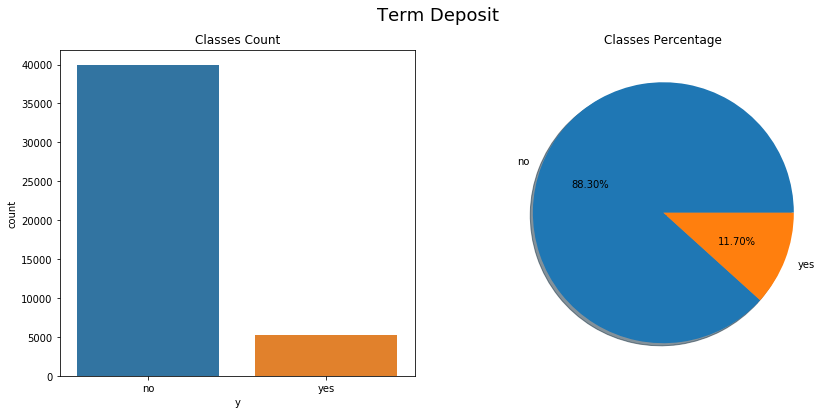

In [0]:
target_perc_plot('y')

# EDA

In [0]:
# *** BANK CLIENT DATA *** #

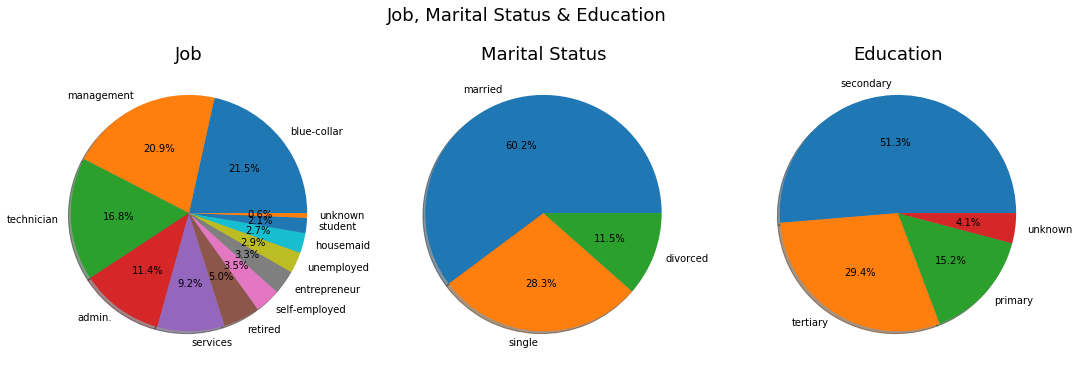

In [0]:
# JOB, MARITAL & EDUCATION

jme = pd.DataFrame(bank, columns=['job', 'marital', 'education', 'y'])
job = jme.groupby('y')['job']
marital = jme.groupby('y')['marital']
edu = jme.groupby('y')['education']

dic_job = dict(bank.job.value_counts())
dic_marital = dict(bank.marital.value_counts())
dic_edu = dict(bank.education.value_counts())

labels_job = list(dic_job.keys())
labels_marital = list(dic_marital.keys())
labels_edu = list(dic_edu.keys())

size_job = list(dic_job.values())
size_marital = list(dic_marital.values())
size_edu = list(dic_edu.values())

fig, ax = plt.subplots(1, 3, figsize=(18,6))
plt.suptitle('Job, Marital Status & Education', fontsize=18)


ax[0].pie(size_job, labels=labels_job, autopct = '%.1f%%', shadow=True)
ax[0].set_title('Job', fontsize=18)
ax[1].pie(size_marital, labels=labels_marital, autopct = '%.1f%%', shadow=True)
ax[1].set_title('Marital Status', fontsize=18)
ax[2].pie(size_edu, labels=labels_edu, autopct = '%.1f%%', shadow=True)
ax[2].set_title('Education', fontsize=18)

plt.show()

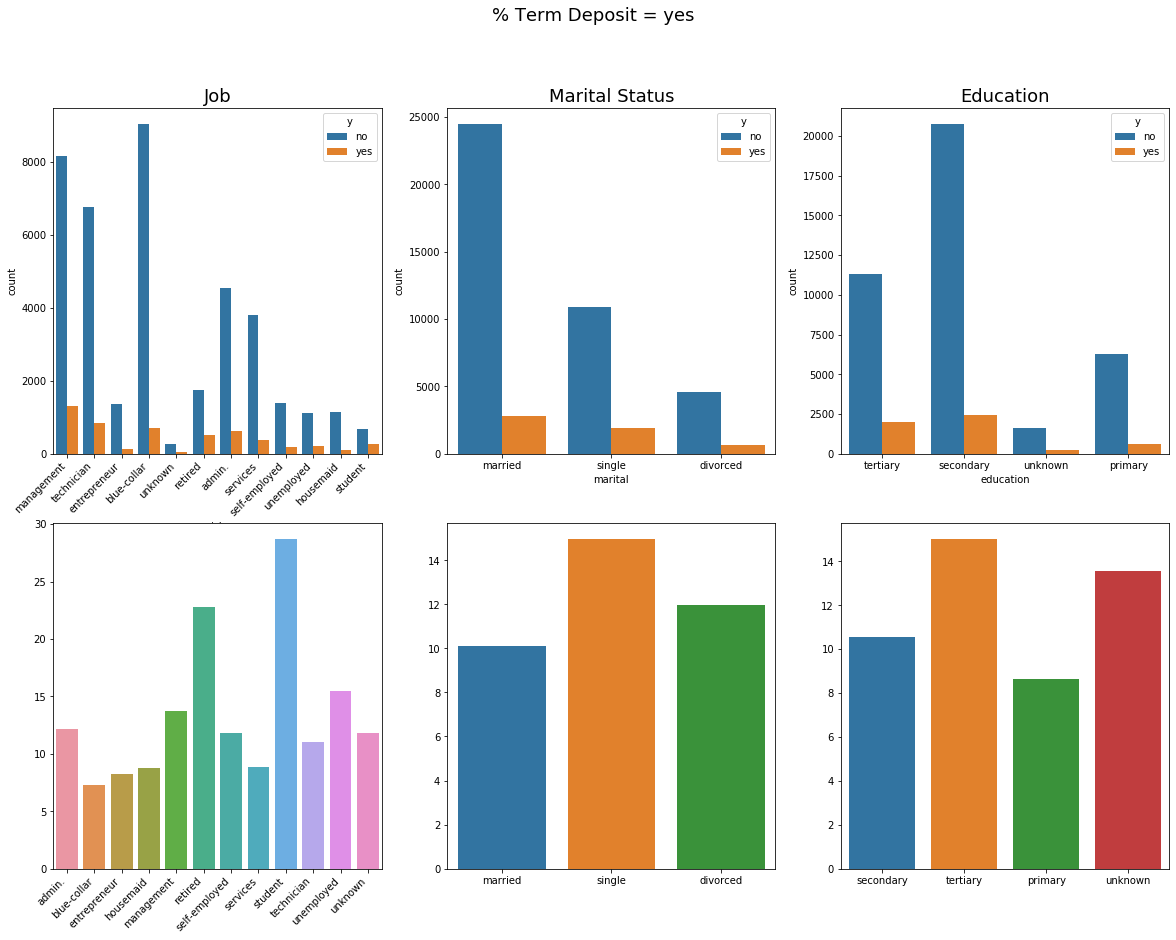

In [0]:
perc_job = (job.get_group('yes').value_counts() / bank.job.value_counts() * 100).to_dict()
perc_marital = (marital.get_group('yes').value_counts() / bank.marital.value_counts() * 100).to_dict()
perc_edu = (edu.get_group('yes').value_counts() / bank.education.value_counts() * 100).to_dict()

y_job = list(perc_job.values())
x_job = list(perc_job.keys())
y_marital = list(perc_marital.values())
x_marital = list(perc_marital.keys())
y_edu = list(perc_edu.values())
x_edu = list(perc_edu.keys())

fig, ax = plt.subplots(2,3, figsize=(20,14))
plt.suptitle('% Term Deposit = yes', fontsize=18)
sns.countplot(bank.job, hue=bank.y, ax=ax[0,0])
ax[0,0].set_xticklabels(ax[0,0].get_xticklabels(), rotation=45, ha='right')
ax[0,0].set_title('Job', fontsize=18)
sns.countplot(bank.marital, hue=bank.y, ax=ax[0,1])
ax[0,1].set_title('Marital Status', fontsize=18)
sns.countplot(bank.education, hue=bank.y, ax=ax[0,2])
ax[0,2].set_title('Education', fontsize=18)
sns.barplot(x=x_job, y=y_job, ax=ax[1,0])
ax[1,0].set_xticklabels(ax[1,0].get_xticklabels(), rotation=45, ha='right')
sns.barplot(x=x_marital, y=y_marital, ax=ax[1,1])
sns.barplot(x=x_edu, y=y_edu, ax=ax[1,2])

plt.show()

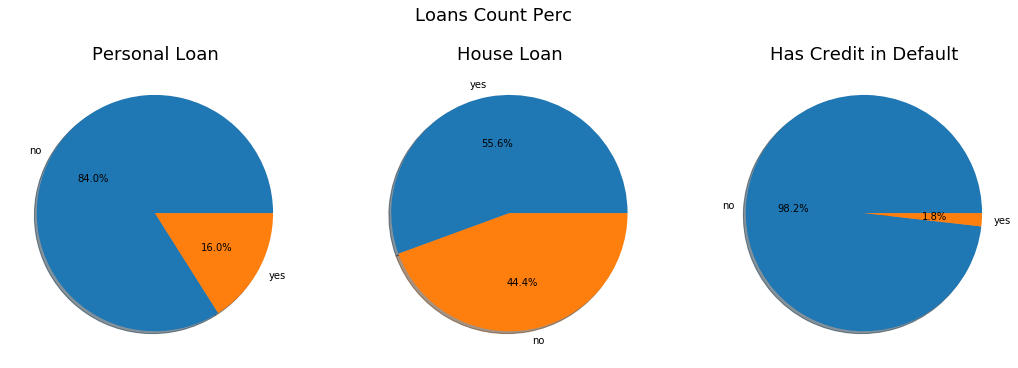

In [0]:
# LOANS

loans = pd.DataFrame(bank, columns=['housing', 'loan','default', 'y'])
loan = loans.groupby('y')['loan']
housing = loans.groupby('y')['housing']
default = loans.groupby('y')['default']

dic_loan = dict(bank.loan.value_counts())
dic_housing = dict(bank.housing.value_counts())
dic_default = dict(bank.default.value_counts())

labels_loan = list(dic_loan.keys())
labels_housing = list(dic_housing.keys())
labels_default = list(dic_default.keys())

size_loan = list(dic_loan.values())
size_housing = list(dic_housing.values())
size_default = list(dic_default.values())

fig, ax = plt.subplots(1, 3, figsize=(18,6))
plt.suptitle('Loans Count Perc', fontsize=18)

ax[0].pie(size_loan, labels=labels_loan, autopct = '%.1f%%', shadow=True)
ax[0].set_title('Personal Loan', fontsize=18)
ax[1].pie(size_housing, labels=labels_housing, autopct = '%.1f%%', shadow=True)
ax[1].set_title('House Loan', fontsize=18)
ax[2].pie(size_default, labels=labels_default, autopct = '%.1f%%', shadow=True)
ax[2].set_title('Has Credit in Default', fontsize=18)

plt.show()

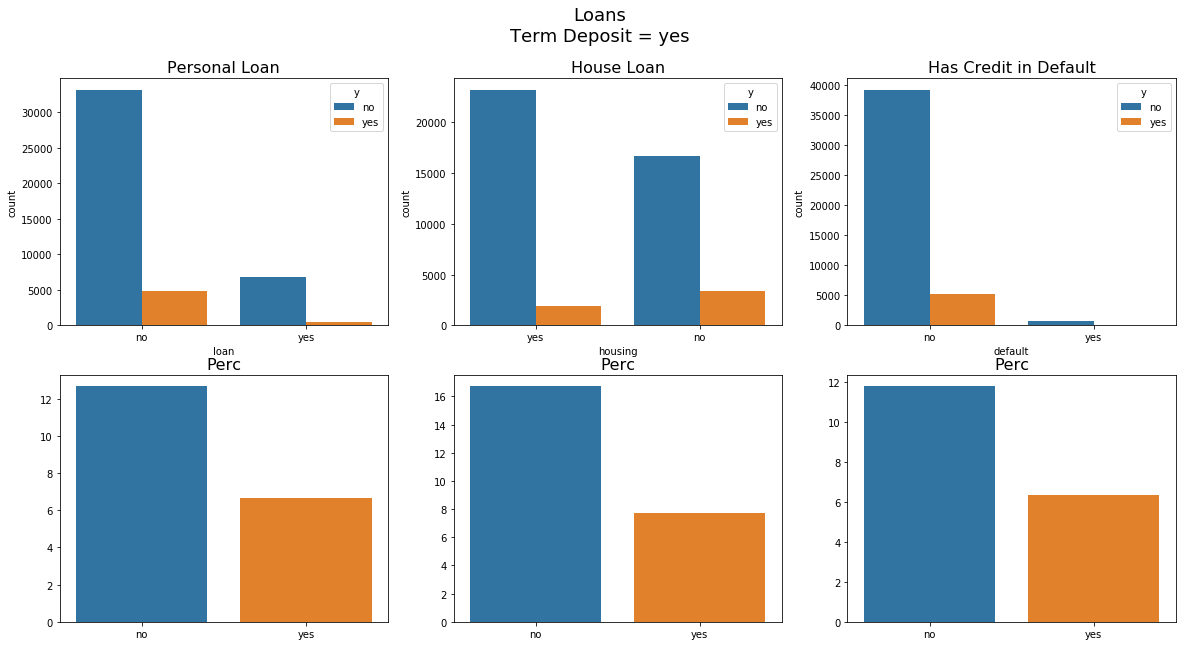

In [0]:
perc_loan = (loan.get_group('yes').value_counts() / bank.loan.value_counts() * 100).to_dict()
perc_housing = (housing.get_group('yes').value_counts() / bank.housing.value_counts() * 100).to_dict()
perc_default = (default.get_group('yes').value_counts() / bank.default.value_counts() * 100).to_dict()

y_loan = list(perc_loan.values())
x_loan = list(perc_loan.keys())
y_housing = list(perc_housing.values())
x_housing = list(perc_housing.keys())
x_default = list(perc_default.keys())
y_default = list(perc_default.values())

fig, ax = plt.subplots(2, 3, figsize=(20,10))
plt.suptitle('Loans\nTerm Deposit = yes', fontsize=18)
sns.countplot(bank.loan, hue=bank.y, ax=ax[0,0])
ax[0,0].set_title('Personal Loan', fontsize=16)
sns.countplot(bank.housing, hue=bank.y, ax=ax[0,1])
ax[0,1].set_title('House Loan', fontsize=16)
sns.countplot(bank.default, hue=bank.y, ax=ax[0,2])
ax[0,2].set_title('Has Credit in Default', fontsize=16)
sns.barplot(x=x_loan, y=y_loan, ax=ax[1,0])
ax[1,0].set_title('Perc', fontsize=16)
sns.barplot(x=x_housing, y=y_housing, ax=ax[1,1])
ax[1,1].set_title('Perc', fontsize=16)
sns.barplot(x=x_default, y=y_default, ax=ax[1,2])
ax[1,2].set_title('Perc', fontsize=16)

plt.show()

In [0]:
# AGE

print('min age:',bank.age.min())
print('max age:',bank.age.max())

min age: 18
max age: 95


Num of Instances: 45211
Upper Limit: 70.5
Lower Limit: 10.5
Num of Outliers: 487
Outliers Perc: 1.08 %


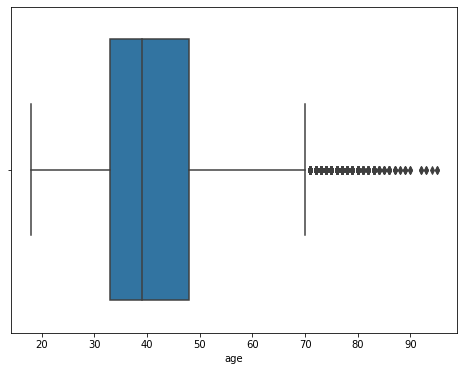

In [0]:
find_outliers('age')

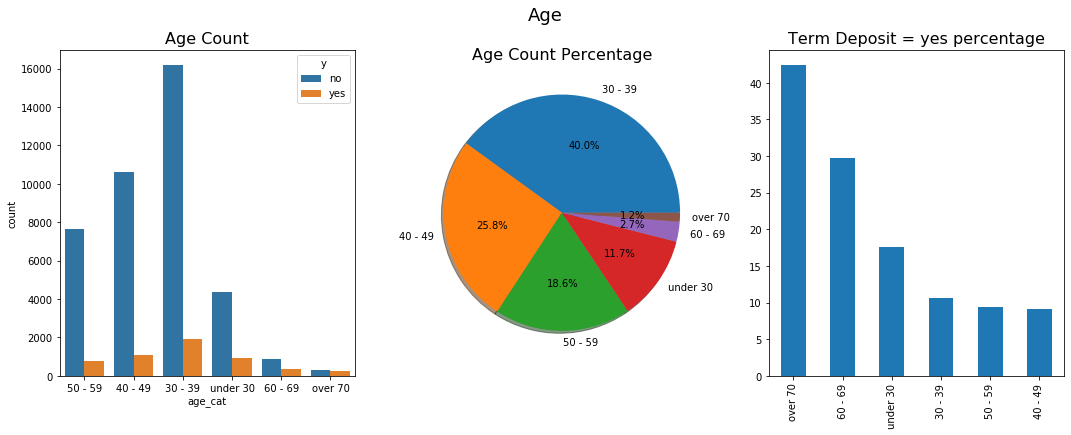

In [0]:
bank['age_cat'] = bank['age']

for age in bank.age_cat:
    if age >=18 and age<30:
        bank.age_cat.replace(to_replace=age, value='under 30', inplace=True)
    elif age >=30 and age<40:
        bank.age_cat.replace(to_replace=age, value='30 - 39', inplace=True)
    elif age >=40 and age<50:
        bank.age_cat.replace(to_replace=age, value='40 - 49', inplace=True)
    elif age >=50 and age<60:
        bank.age_cat.replace(to_replace=age, value='50 - 59', inplace=True)
    elif age >=60 and age<70:
        bank.age_cat.replace(to_replace=age, value='60 - 69', inplace=True)
    else:
        bank.age_cat.replace(to_replace=age, value='over 70', inplace=True)

age = pd.DataFrame(bank, columns=['age_cat','y'])
age = age.groupby('y')['age_cat']
perc = (age.get_group('yes').value_counts() / bank.age_cat.value_counts() * 100).sort_values(ascending=False)
dic = dict(bank.age_cat.value_counts())
labels = list(dic.keys())
size = list(dic.values())

fig, ax = plt.subplots(1,3, figsize=(18,6))
plt.suptitle('Age', fontsize=18)
sns.countplot(bank.age_cat, hue=bank.y, ax=ax[0])
ax[0].set_title('Age Count', fontsize=16)
ax[2] = perc.plot(kind='bar')
ax[2].set_title('Term Deposit = yes percentage', fontsize=16)
ax[1].pie(size, labels=labels, autopct = '%.1f%%', shadow=True)
ax[1].set_title('Age Count Percentage', fontsize=16)
plt.show()

Conclusion Age:

 - All ages above 70 are outliers.
 - It seems that the ages that are 60+ are more likely to make a term deposit

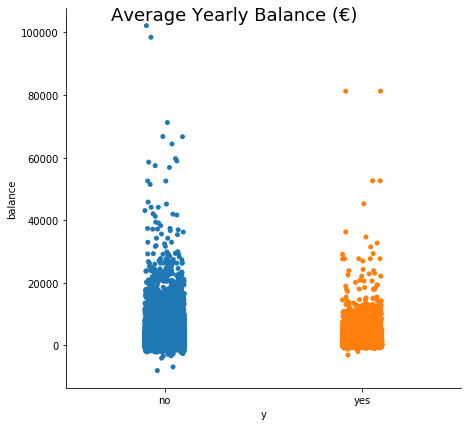

In [0]:
# BALANCE 
ax = sns.catplot(x='y', y='balance', data=bank, height=6, aspect=1.1)
ax.fig.suptitle('Average Yearly Balance (€)', fontsize=18)

plt.show()

In [0]:
# **** LAST CONTACT OF CURRENT CAMPAIGN **** #

In [0]:
# DURATION

duration_min = round(bank.duration/60, 1)
print('Max duration:',duration_min.max())
print('Min duration:',duration_min.min())

Max duration: 82.0
Min duration: 0.0


Num of Instances: 45211
Upper Limit: 10.7
Lower Limit: -3.6999999999999993
Num of Outliers: 3222
Outliers Perc: 7.13 %


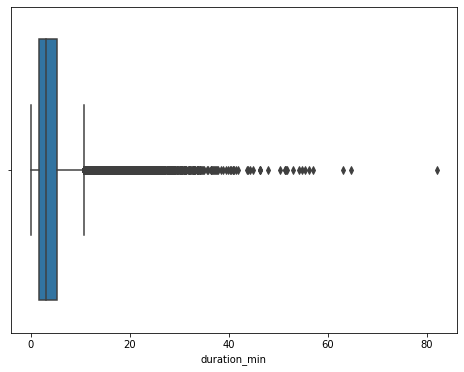

In [0]:
bank['duration_min'] = round(bank.duration/60, 1)
find_outliers('duration_min')

In [0]:
bank[bank['duration']==0]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,age_cat,duration_min
6424,53,management,married,primary,no,351,yes,no,unknown,27,may,0,4,-1,0,unknown,no,50 - 59,0.0
22937,35,technician,married,secondary,no,5535,no,no,cellular,26,aug,0,15,-1,0,unknown,no,30 - 39,0.0
36425,31,entrepreneur,married,secondary,no,162,yes,yes,cellular,11,may,0,2,-1,0,unknown,no,30 - 39,0.0


In [0]:
bank[bank.duration>3600]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,age_cat,duration_min
9947,59,management,married,secondary,no,1321,no,no,unknown,9,jun,3881,3,-1,0,unknown,yes,50 - 59,64.7
24148,59,technician,married,tertiary,no,6573,yes,no,telephone,10,nov,4918,1,-1,0,unknown,no,50 - 59,82.0
44602,45,services,single,secondary,no,955,no,no,unknown,27,aug,3785,1,-1,0,unknown,no,40 - 49,63.1


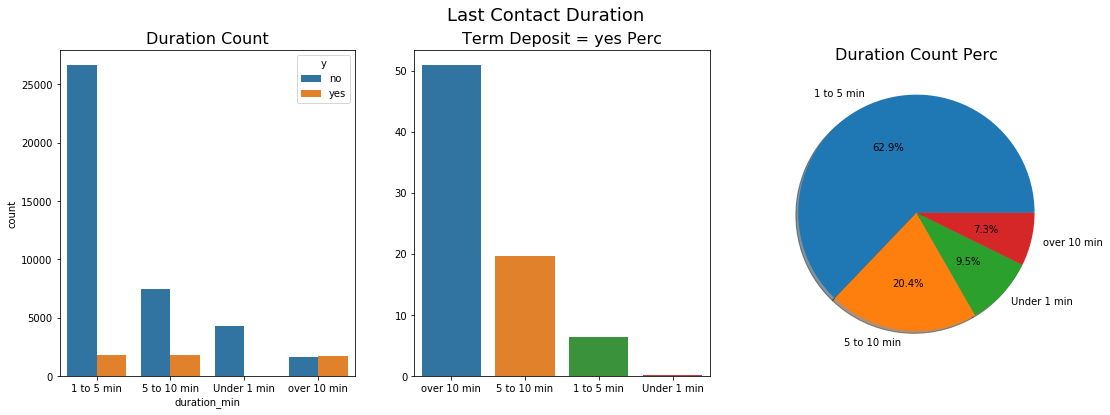

In [0]:
for dur in bank.duration_min:
    if dur < 1:
        bank.duration_min.replace(to_replace=dur, value='Under 1 min', inplace=True)
    elif dur >= 1 and dur < 5:
        bank.duration_min.replace(to_replace=dur, value='1 to 5 min', inplace=True)
    elif dur >=5 and dur < 10.7:
        bank.duration_min.replace(to_replace=dur, value='5 to 10 min', inplace=True)
    else:
        bank.duration_min.replace(to_replace=dur, value='over 10 min', inplace=True)

duration = pd.DataFrame(bank, columns=['duration_min','y'])
dur = duration.groupby('y')['duration_min']
perc = (dur.get_group('yes').value_counts() / duration.duration_min.value_counts() * 100).sort_values(ascending=False).to_dict()
dic = bank.duration_min.value_counts().to_dict()
labels = list(dic.keys())
size = list(dic.values())
x_dur = list(perc.keys())
y_dur = list(perc.values())

fig, ax = plt.subplots(1,3, figsize=(18,6))
plt.suptitle('Last Contact Duration', fontsize=18)
sns.countplot(bank.duration_min, hue=bank.y, ax=ax[0])
ax[0].set_title('Duration Count', fontsize=16)
sns.barplot(x=x_dur, y=y_dur, ax=ax[1])
ax[1].set_title('Term Deposit = yes Perc', fontsize=16)
ax[2].pie(size, labels=labels, autopct = '%.1f%%', shadow=True)
ax[2].set_title('Duration Count Perc', fontsize=16)
plt.show()

Conclusion Duration:

 - all contacts duration that above 10.7 minutes are outliers
 - it seems that call under 1 minute has almost no chance to produce a term deposit
 - calls over 10 minutes has the highest chance to produce a term deposit
 - calls durations with value 0 are useless and has a pre-known outcome and will be deleted 

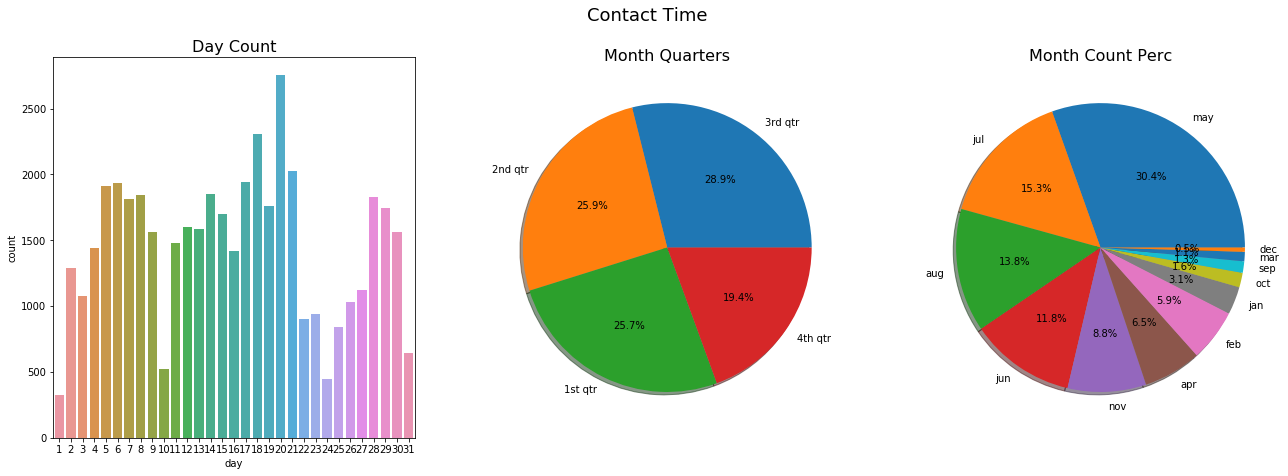

In [0]:
# DATE

bank['month_qtr'] = bank['day']

for day in bank['month_qtr']:
    if day >= 1 and day < 9:
        bank.month_qtr.replace(to_replace=day, value='1st qtr', inplace=True)
    elif day >= 9 and day < 17:
        bank.month_qtr.replace(to_replace=day, value='2nd qtr', inplace=True)
    elif day >= 17 and day < 25:
        bank.month_qtr.replace(to_replace=day, value='3rd qtr', inplace=True)
    else:
        bank.month_qtr.replace(to_replace=day, value='4th qtr', inplace=True)

dic_day = dict(bank.day.value_counts())
dic_month_qtr = dict(bank.month_qtr.value_counts())
dic_month = dict(bank.month.value_counts())

labels_day = list(dic_day.keys())
labels_month = list(dic_month.keys())
labels_month_qtr = list(dic_month_qtr.keys())

size_day = list(dic_day.values())
size_month = list(dic_month.values())
size_month_qtr = list(dic_month_qtr.values())

fig, ax = plt.subplots(1, 3, figsize=(22,7))
plt.suptitle('Contact Time', fontsize=18)
sns.countplot(bank.day, ax=ax[0])
ax[0].set_title('Day Count', fontsize=16)
ax[2].pie(size_month, labels=labels_month, autopct = '%.1f%%', shadow=True)
ax[2].set_title('Month Count Perc', fontsize=16)
ax[1].pie(size_month_qtr, labels=labels_month_qtr, autopct = '%.1f%%', shadow=True)
ax[1].set_title('Month Quarters',fontsize=16)

plt.show()

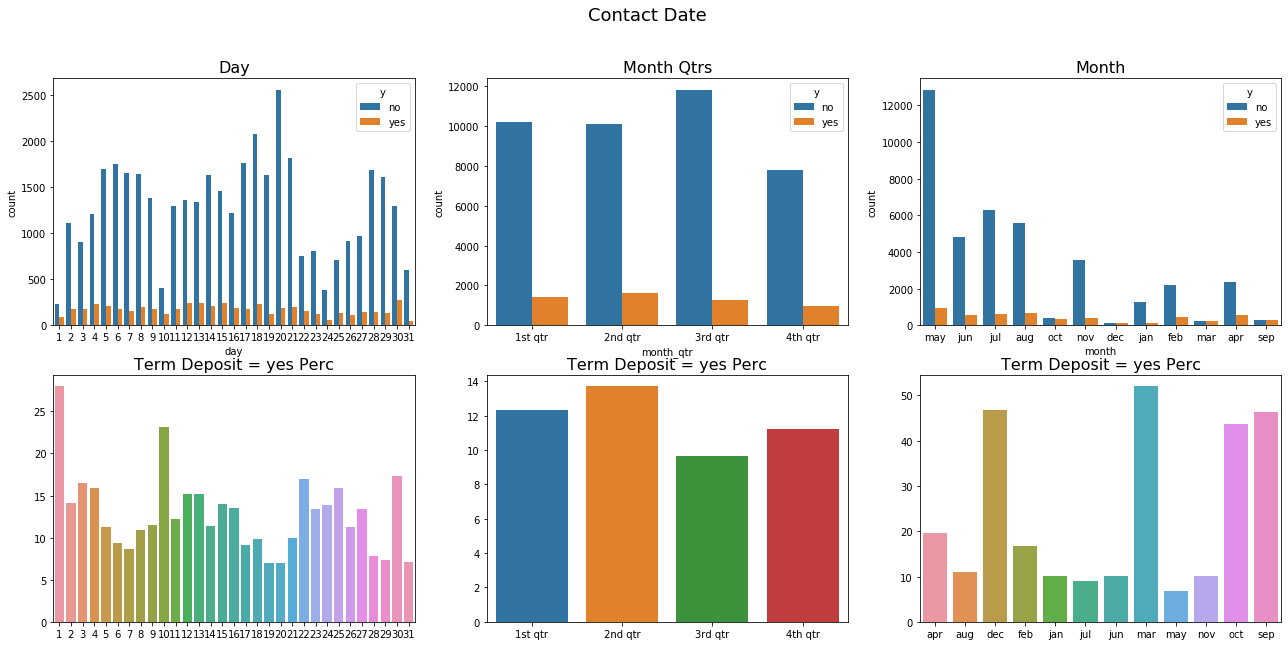

In [0]:
time = pd.DataFrame(bank, columns=['month', 'day','month_qtr', 'y'])
day = time.groupby('y')['day']
month = time.groupby('y')['month']
month_qtr = time.groupby('y')['month_qtr']

perc_day = (day.get_group('yes').value_counts() / bank.day.value_counts() * 100).to_dict()
perc_month = (month.get_group('yes').value_counts() / bank.month.value_counts() * 100).to_dict()
perc_month_qtr = (month_qtr.get_group('yes').value_counts() / bank.month_qtr.value_counts() * 100).to_dict()

y_day = list(perc_day.values())
x_day = list(perc_day.keys())
y_month = list(perc_month.values())
x_month = list(perc_month.keys())
x_month_qtr = list(perc_month_qtr.keys())
y_month_qtr = list(perc_month_qtr.values())

fig, ax = plt.subplots(2, 3, figsize=(22,10))
plt.suptitle('Contact Date', fontsize=18)
sns.countplot(bank.day, hue=bank.y, ax=ax[0,0])
ax[0,0].set_title('Day', fontsize=16)
sns.countplot(bank.month, hue=bank.y, ax=ax[0,2])
ax[0,2].set_title('Month', fontsize=16)
sns.barplot(x=x_day, y=y_day, ax=ax[1,0])
ax[1,0].set_title('Term Deposit = yes Perc', fontsize=16)
sns.barplot(x=x_month, y=y_month, ax=ax[1,2])
ax[1,2].set_title('Term Deposit = yes Perc', fontsize=16)
sns.countplot(bank.month_qtr, hue=bank.y, ax=ax[0,1])
ax[0,1].set_title('Month Qtrs', fontsize=16)
sns.barplot(x=x_month_qtr, y=y_month_qtr, ax=ax[1,1])
ax[1,1].set_title('Term Deposit = yes Perc', fontsize=16)

plt.show()

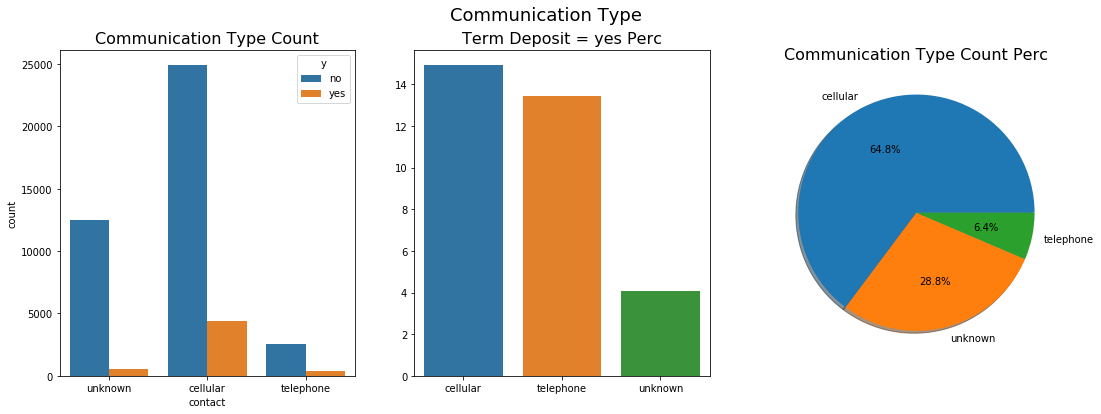

In [0]:
# COMMUNICATION TYPE

contact = pd.DataFrame(bank, columns=['contact','y'])
con = contact.groupby('y')['contact']
perc = (con.get_group('yes').value_counts() / contact.contact.value_counts() * 100).sort_values(ascending=False).to_dict()
dic = bank.contact.value_counts().to_dict()
labels = list(dic.keys())
size = list(dic.values())
x_con = list(perc.keys())
y_con = list(perc.values())

fig, ax = plt.subplots(1,3, figsize=(18,6))
plt.suptitle('Communication Type', fontsize=18)
sns.countplot(bank.contact, hue=bank.y, ax=ax[0])
ax[0].set_title('Communication Type Count', fontsize=16)
sns.barplot(x=x_con, y=y_con, ax=ax[1])
ax[1].set_title('Term Deposit = yes Perc', fontsize=16)
ax[2].pie(size, labels=labels, autopct = '%.1f%%', shadow=True)
ax[2].set_title('Communication Type Count Perc', fontsize=16)
plt.show()

In [0]:
# CAMPAIGN ATTRIBUTES

In [0]:
# CAMPAIGN

print('Min Contacts for Current Campaign:',bank.campaign.min())
print('Max Contacts for Current Campaign:',bank.campaign.max())

Min Contacts for Current Campaign: 1
Max Contacts for Current Campaign: 63


Num of Instances: 45211
Upper Limit: 6.0
Lower Limit: -2.0
Num of Outliers: 3064
Outliers Perc: 6.78 %


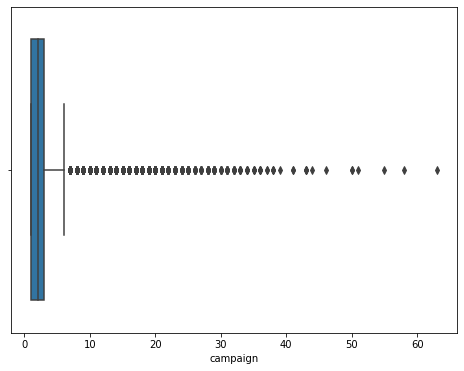

In [0]:
find_outliers('campaign')

In [0]:
bank[bank.campaign>45]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,age_cat,duration_min,month_qtr
4299,30,management,single,tertiary,no,358,yes,no,unknown,19,may,88,51,-1,0,unknown,no,30 - 39,1 to 5 min,3rd qtr
4330,45,management,married,unknown,no,9051,yes,no,unknown,19,may,124,63,-1,0,unknown,no,40 - 49,1 to 5 min,3rd qtr
5073,35,technician,married,secondary,no,432,yes,no,unknown,21,may,1094,55,-1,0,unknown,no,30 - 39,over 10 min,3rd qtr
5459,35,blue-collar,married,secondary,no,430,yes,no,unknown,23,may,147,50,-1,0,unknown,no,30 - 39,1 to 5 min,3rd qtr
10697,28,blue-collar,single,secondary,no,235,yes,no,unknown,16,jun,102,46,-1,0,unknown,no,under 30,1 to 5 min,2nd qtr
11914,24,technician,single,primary,no,126,yes,no,unknown,20,jun,10,58,-1,0,unknown,no,under 30,Under 1 min,3rd qtr
18713,35,blue-collar,married,secondary,no,280,yes,yes,cellular,31,jul,65,50,-1,0,unknown,no,30 - 39,1 to 5 min,4th qtr


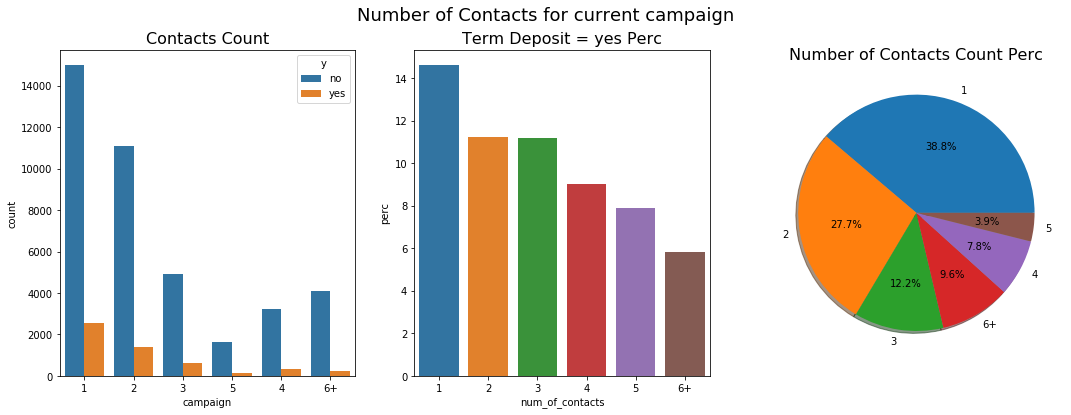

In [0]:
campaign = pd.DataFrame(bank, columns=['campaign', 'y'])

for con in campaign.campaign:
    if con == 1:
        campaign.campaign.replace(to_replace=con, value=1, inplace=True)
    elif con == 2:
        campaign.campaign.replace(to_replace=con, value=2, inplace=True)
    elif con == 3:
        campaign.campaign.replace(to_replace=con, value=3, inplace=True)
    elif con == 4:
        campaign.campaign.replace(to_replace=con, value=4, inplace=True)
    elif con == 5:
        campaign.campaign.replace(to_replace=con, value=5, inplace=True)
    else:
        campaign.campaign.replace(to_replace=con, value='6+', inplace=True)
        
cam = campaign.groupby('y')['campaign']
perc_cam = (cam.get_group('yes').value_counts() / campaign.campaign.value_counts() * 100).sort_values(ascending=False).to_dict()
dic_cam = campaign.campaign.value_counts().to_dict()
labels_cam = list(dic_cam.keys())
size_cam = list(dic_cam.values())
x_cam = list(perc_cam.keys())
y_cam = list(perc_cam.values())
pc = pd.DataFrame(list(zip(x_cam, y_cam)),columns=['num_of_contacts', 'perc'])

fig, ax = plt.subplots(1,3, figsize=(18,6))
plt.suptitle('Number of Contacts for current campaign', fontsize=18)
sns.countplot(campaign.campaign, hue=bank.y, ax=ax[0])
ax[0].set_title('Contacts Count', fontsize=16)
sns.barplot(x='num_of_contacts', y='perc', data=pc, ax=ax[1])
ax[1].set_title('Term Deposit = yes Perc', fontsize=16)
ax[2].pie(size_cam, labels=labels_cam, autopct = '%.1f%%', shadow=True)
ax[2].set_title('Number of Contacts Count Perc', fontsize=16)

plt.show()

Conclusion Contacts Number:
 - as the num of contacts rises, the less likely there will ba a term deposit
 - num of contacts above 6 are outliers

In [0]:
# TIME PASSED FROM PREVIOUS CAMPAIGN CONTACT

for p in bank.pdays:
    if p == -1:
        bank.pdays.replace(to_replace=p, value=0, inplace=True)

print('Min Days Passed From Previous Campaign Contact:',bank.pdays.min())
print('Max Days Passed From Previous Campaign Contact:',bank.pdays.max())

Min Days Passed From Previous Campaign Contact: 0
Max Days Passed From Previous Campaign Contact: 871


Num of Instances: 45211
Upper Limit: 0.0
Lower Limit: 0.0
Num of Outliers: 8257
Outliers Perc: 18.26 %


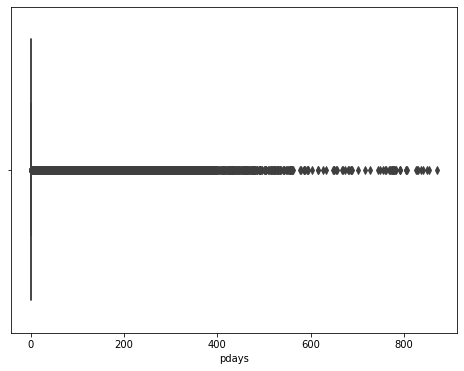

In [0]:
find_outliers('pdays')

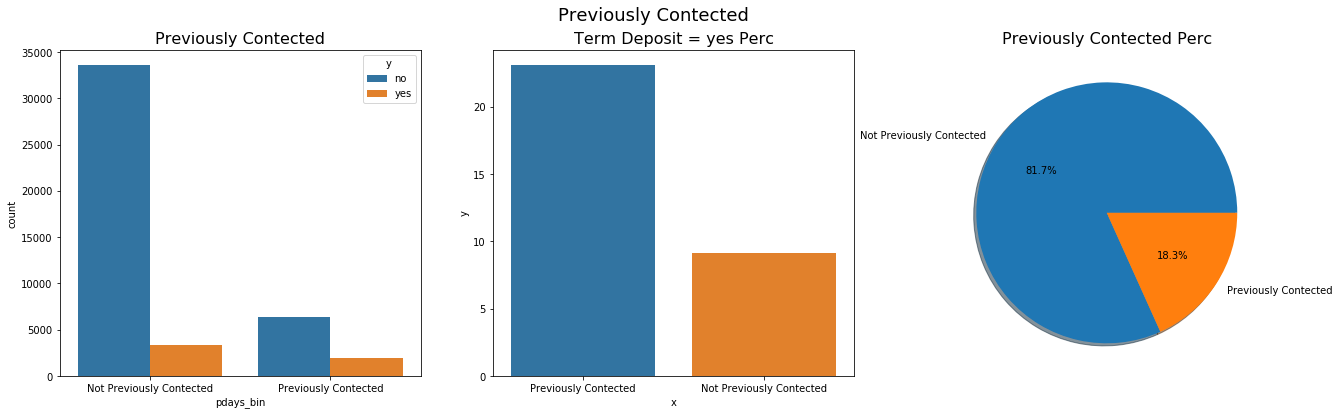

In [0]:
bank['pdays_bin'] = bank.pdays
pdays = pd.DataFrame(bank, columns=['pdays_bin', 'y'])

for c in pdays['pdays_bin']:
    if c == 0:
        pdays.pdays_bin.replace(to_replace=c, value='Not Previously Contected', inplace=True)
    else:
        pdays.pdays_bin.replace(to_replace=c, value='Previously Contected', inplace=True)

day = pdays.groupby('y')['pdays_bin']
perc_pday = (day.get_group('yes').value_counts() / pdays.pdays_bin.value_counts() * 100).sort_values(ascending=False).to_dict()
dic_pday = pdays.pdays_bin.value_counts().to_dict()
labels_pday = list(dic_pday.keys())
size_pday = list(dic_pday.values())
x_pday = list(perc_pday.keys())
y_pday = list(perc_pday.values())
pdays_2 = pd.DataFrame(list(zip(x_pday, y_pday)),columns=['x', 'y'])

fig, ax = plt.subplots(1,3, figsize=(22,6))
plt.suptitle('Previously Contected', fontsize=18)
sns.countplot(pdays.pdays_bin, hue=bank.y, ax=ax[0])
ax[0].set_title('Previously Contected', fontsize=16)
sns.barplot(x='x', y='y', data=pdays_2, ax=ax[1])
ax[1].set_title('Term Deposit = yes Perc', fontsize=16)
ax[2].pie(size_pday, labels=labels_pday, autopct = '%.1f%%', shadow=True)
ax[2].set_title('Previously Contected Perc', fontsize=16)

plt.show()

In [0]:
# NUMBER OF PREVIOUS CONTACTS

print('Min Number of Previously Contacts:',bank.previous.min())
print('Max Number of Previously Contacts:',bank.previous.max())

Min Number of Previously Contacts: 0
Max Number of Previously Contacts: 275


Num of Instances: 45211
Upper Limit: 0.0
Lower Limit: 0.0
Num of Outliers: 8257
Outliers Perc: 18.26 %


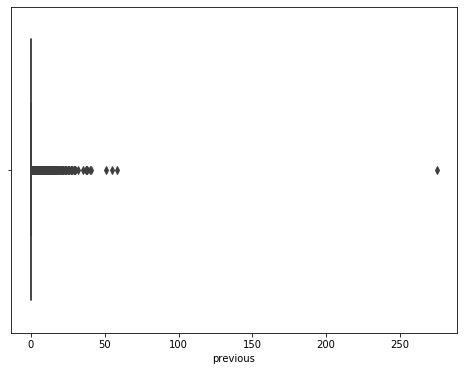

In [0]:
find_outliers('previous')

In [0]:
bank[bank.previous>50]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,age_cat,duration_min,month_qtr,pdays_bin
28886,31,management,single,tertiary,no,358,yes,no,cellular,30,jan,68,3,256,51,failure,no,30 - 39,1 to 5 min,4th qtr,256
29182,40,management,married,tertiary,no,543,yes,no,cellular,2,feb,349,2,262,275,other,no,40 - 49,5 to 10 min,1st qtr,262
38326,46,blue-collar,married,primary,no,1085,yes,yes,cellular,15,may,523,2,353,58,other,yes,40 - 49,5 to 10 min,2nd qtr,353
44089,37,technician,married,secondary,no,432,yes,no,cellular,6,jul,386,3,776,55,failure,yes,30 - 39,5 to 10 min,1st qtr,776


          previous     pdays
previous  1.000000  0.454288
pdays     0.454288  1.000000


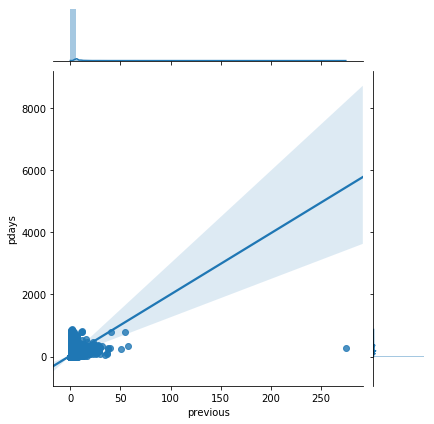

In [0]:
print(bank[['previous', 'pdays']].corr())
sns.jointplot(x='previous', y='pdays', data=bank, kind='reg')

plt.show()

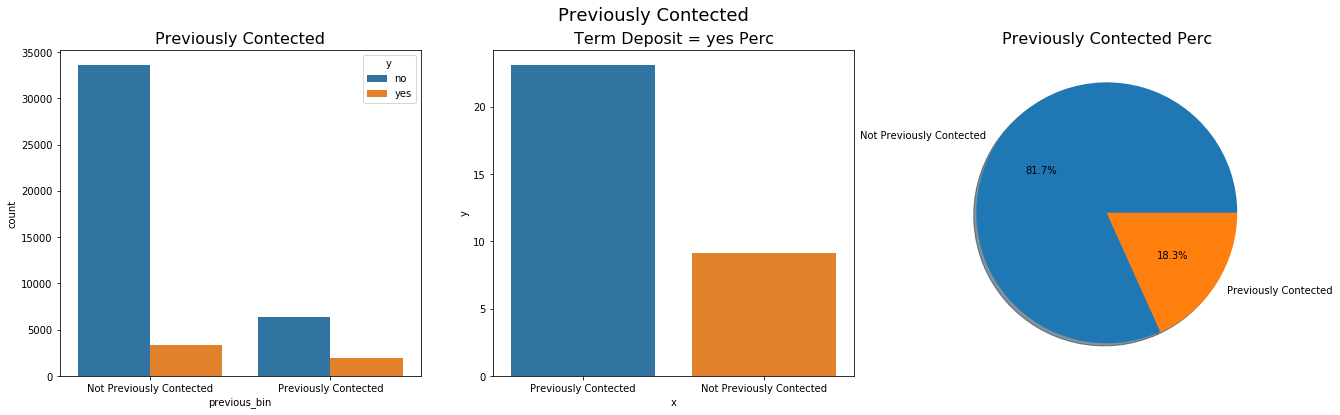

In [0]:
bank['previous_bin'] = bank.previous
previous = pd.DataFrame(bank, columns=['previous_bin', 'y'])

for c in previous['previous_bin']:
    if c == 0:
        previous.previous_bin.replace(to_replace=c, value='Not Previously Contected', inplace=True)
    else:
        previous.previous_bin.replace(to_replace=c, value='Previously Contected', inplace=True)

prev = previous.groupby('y')['previous_bin']
perc_prev = (prev.get_group('yes').value_counts() / previous.previous_bin.value_counts() * 100).sort_values(ascending=False).to_dict()
dic_prev = previous.previous_bin.value_counts().to_dict()
labels_prev = list(dic_prev.keys())
size_prev = list(dic_prev.values())
x_prev = list(perc_prev.keys())
y_prev = list(perc_prev.values())
prev_2 = pd.DataFrame(list(zip(x_prev, y_prev)),columns=['x', 'y'])

fig, ax = plt.subplots(1,3, figsize=(22,6))
plt.suptitle('Previously Contected', fontsize=18)
sns.countplot(previous.previous_bin, hue=bank.y, ax=ax[0])
ax[0].set_title('Previously Contected', fontsize=16)
sns.barplot(x='x', y='y', data=prev_2, ax=ax[1])
ax[1].set_title('Term Deposit = yes Perc', fontsize=16)
ax[2].pie(size_prev, labels=labels_prev, autopct = '%.1f%%', shadow=True)
ax[2].set_title('Previously Contected Perc', fontsize=16)

plt.show()

Conclusion Pdays and Previous:
 - because of the similarity of both features, I will create a new feture which tells if the client had a contect of previous marketing campaign or not.

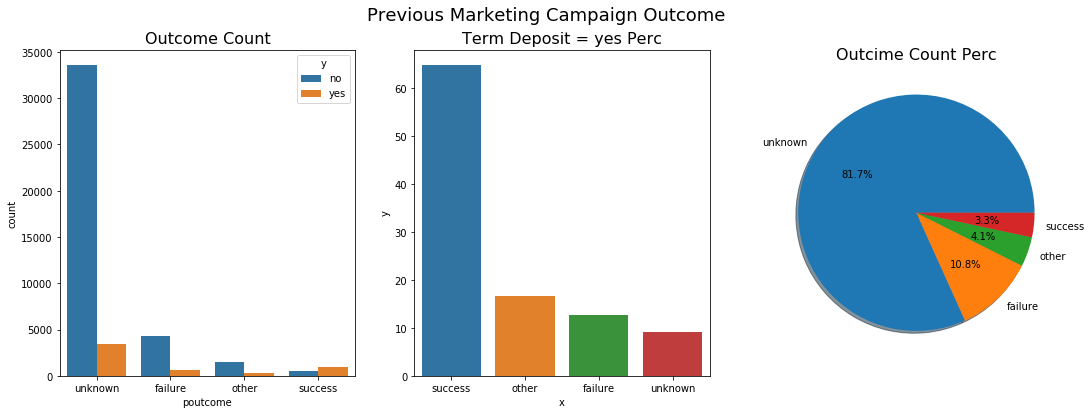

In [0]:
# PREVIOUS MARKETING CAMPAIGN OUTCOME

poutcome = pd.DataFrame(bank, columns=['poutcome', 'y'])
out = poutcome.groupby('y')['poutcome']
perc_out = (out.get_group('yes').value_counts() / poutcome.poutcome.value_counts() * 100).sort_values(ascending=False).to_dict()
dic_out = poutcome.poutcome.value_counts().to_dict()
labels_out = list(dic_out.keys())
size_out = list(dic_out.values())
x_out = list(perc_out.keys())
y_out = list(perc_out.values())
po = pd.DataFrame(list(zip(x_out, y_out)),columns=['x', 'y'])

fig, ax = plt.subplots(1,3, figsize=(18,6))
plt.suptitle('Previous Marketing Campaign Outcome', fontsize=18)
sns.countplot(poutcome.poutcome, hue=bank.y, ax=ax[0])
ax[0].set_title('Outcome Count', fontsize=16)
sns.barplot(x='x', y='y', data=po, ax=ax[1])
ax[1].set_title('Term Deposit = yes Perc', fontsize=16)
ax[2].pie(size_out, labels=labels_out, autopct = '%.1f%%', shadow=True)
ax[2].set_title('Outcime Count Perc', fontsize=16)

plt.show()

Conclusion Previous Outcome:
 - it seems that the clients that did a term deposit on a previous campaign are more likely to do it again the a "new" client.

# Data Preperation

In [0]:
# **** DATA PROCESSING **** #

In [0]:
bank.drop(['pdays_bin', 'previous_bin'], axis=1, inplace=True)
bank['pre_contacted'] = pdays.pdays_bin
bank.pre_contacted.replace(to_replace='Not Previously Contected' ,value='No', inplace=True)
bank.pre_contacted.replace(to_replace='Previously Contected' ,value='yes', inplace=True)

bank['campaign_cat'] = campaign.campaign

bank.drop(bank[bank.duration==0].index, inplace=True)
bank.drop(bank[bank.previous>50].index, inplace=True)
bank.drop(bank[bank.duration>3600].index, inplace=True)
bank.drop(bank[bank.campaign>45].index, inplace=True)

le = LabelEncoder()
bank.default = le.fit_transform(bank.default)
bank.housing = le.fit_transform(bank.housing)
bank.loan = le.fit_transform(bank.loan)
bank.y = le.fit_transform(bank.y)
bank.pre_contacted = le.fit_transform(bank.pre_contacted)

In [0]:
bank.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,age_cat,duration_min,month_qtr,pre_contacted,campaign_cat
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,261,1,0,0,unknown,0,50 - 59,1 to 5 min,1st qtr,0,1
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,151,1,0,0,unknown,0,40 - 49,1 to 5 min,1st qtr,0,1
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,76,1,0,0,unknown,0,30 - 39,1 to 5 min,1st qtr,0,1


In [0]:
# bank_enc = pd.DataFrame(bank)

# bank_enc.duration_min = bank_enc.duration_min.map({'Under 1 min':1, '1 to 5 min':2,
#                                                    '5 to 10 min':3, 'over 10 min':4})

# bank_enc.age_cat = bank_enc.age_cat.map({'under 30':1, '30 - 39':2, '40 - 49':3,
#                                          '50 - 59':4, '60 - 69':5, 'over 70':6})

# bank_enc.campaign_cat = bank_enc.campaign_cat.map({1:1, 2:2, 3:3, 4:4, 5:5, '6+':6})

# bank_enc.month_qtr = bank_enc.month_qtr.map({'1st qtr':1, '2nd qtr':2, '3rd qtr':3, '4th qtr':4})

In [0]:
bank_f = pd.DataFrame(bank, copy=True)

In [0]:
bank_f.drop(['age_cat', 'duration_min', 'month_qtr', 
             'pre_contacted', 'campaign_cat'], axis=1, inplace=True)

bank_f = pd.get_dummies(bank_f, columns=['job', 'marital', 'education',
                                         'contact', 'month', 'poutcome'])

In [0]:
bank_f.shape

(45194, 49)

In [0]:
scaled_f = MinMaxScaler(feature_range=(0,1)).fit_transform(bank_f)
bank_final = pd.DataFrame(scaled_f, columns=bank_f.columns)
bank_final.head(3)

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,0.519481,0.0,0.092259,1.0,0.0,0.133333,0.076001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.337662,0.0,0.073067,1.0,0.0,0.133333,0.043847,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.194805,0.0,0.072822,1.0,1.0,0.133333,0.021923,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [0]:
X_f = bank_final.drop('y', axis=1)
y_f = bank_final.y

x_f_train, x_f_test, y_f_train, y_f_test = split(X_f, y_f, test_size=0.2)

In [0]:
# ***** FEATURE SELECTION **** #

In [0]:
# feature_name = list(X.columns)
# num_feats = 5

# chi_selector = SelectKBest(chi2, k=num_feats)
# chi_selector.fit(X, y)
# chi_support = chi_selector.get_support()
# chi_feature = X.loc[:,chi_support].columns.tolist()
# print(str(len(chi_feature)), 'selected features')

# rfe_selector = RFE(estimator=LogisticRegression(class_weight='balanced'), n_features_to_select=num_feats, step=2, verbose=5)
# rfe_selector.fit(X, y)

# rfe_support = rfe_selector.get_support()
# rfe_feature = X.loc[:,rfe_support].columns.tolist()
# print(str(len(rfe_feature)), 'selected features')

# embeded_lr_selector = SelectFromModel(LogisticRegression(class_weight='balanced'), max_features=num_feats)
# embeded_lr_selector.fit(X, y)

# embeded_lr_support = embeded_lr_selector.get_support()
# embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
# print(str(len(embeded_lr_feature)), 'selected features')

# embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=200,
#                                                              class_weight='balanced'), max_features=num_feats)
# embeded_rf_selector.fit(X, y)

# embeded_rf_support = embeded_rf_selector.get_support()
# embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
# print(str(len(embeded_rf_feature)), 'selected features')

# feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Chi-2':chi_support,
#                                      'RFE':rfe_support, 'Random Forest':embeded_rf_support,
#                                      'Logistics':embeded_lr_support})

# feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)

# feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
# feature_selection_df.index = range(1, len(feature_selection_df)+1)
# feature_selection_df.head(num_feats)

# Models

Number of features selected: 20
Test Accuracy 0.9002102002433897
[[7760  195]
 [ 707  377]]


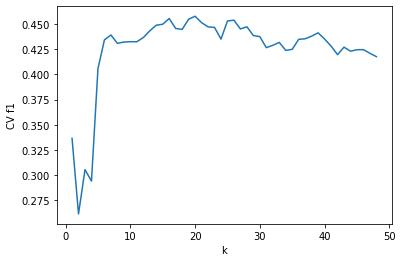

In [0]:
# RANDOM FOREST #

# ***** FEATURE SELECTION **** #

# RFE

rfe = RFECV(RandomForestClassifier(class_weight='balanced', n_estimators=100), cv=5, scoring='f1')
rfe = rfe.fit(x_f_train, y_f_train)
 
cols = x_f_train.columns[rfe.support_]
acc = accuracy_score(y_f_test, rfe.estimator_.predict(x_f_test[cols]))
print('Number of features selected: {}'.format(rfe.n_features_))
print('Test Accuracy {}'.format(acc))
print(confusion_matrix(y_f_test, rfe.estimator_.predict(x_f_test[cols])))
 
plt.figure()
plt.xlabel('k')
plt.ylabel('CV f1')
plt.plot(np.arange(1, rfe.grid_scores_.size+1), rfe.grid_scores_)
plt.show()

In [0]:
print(classification_report(y_f_test, rfe.estimator_.predict(x_f_test[cols])))

              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95      7955
         1.0       0.66      0.35      0.46      1084

    accuracy                           0.90      9039
   macro avg       0.79      0.66      0.70      9039
weighted avg       0.89      0.90      0.89      9039



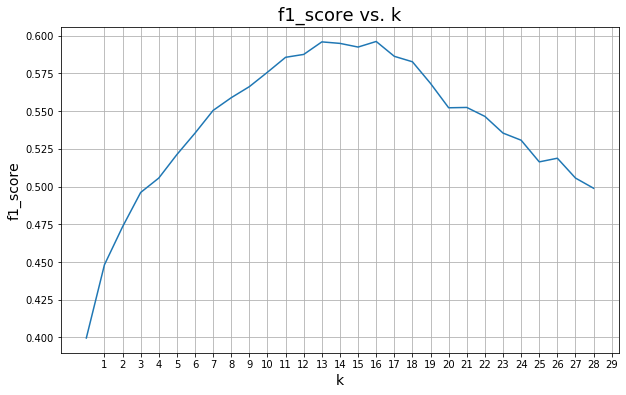

In [0]:
f1_scores = []
for k in range(1, 30):
    model = RandomForestClassifier(n_estimators=200, max_depth=k, 
                                   class_weight='balanced', max_features=20).fit(x_f_train, y_f_train)
    f1_scores.append(f1_score(y_true=y_f_test,
                              y_pred=model.predict(x_f_test)))

plt.figure(figsize=(10,6))
plt.plot(f1_scores)
plt.xlabel('k', fontsize=14)
plt.xticks(range(1,30))
plt.ylabel('f1_score', fontsize=14)
plt.title('f1_score vs. k', fontsize=18)
plt.grid()

plt.show()

In [0]:
RF_f = RandomForestClassifier(max_features=20, n_estimators=200, max_depth=14, class_weight='balanced')

scores = cross_val_score(RF_f, x_f_train, y_f_train, cv=10)

print("Scores :",scores)
print("Average:",scores.mean())
print("STD:", scores.std())

Scores : [0.89217584 0.88664639 0.89518805 0.89681881 0.89183956 0.89460581
 0.90041494 0.89571231 0.89045643 0.88769018]
Average: 0.8931548317424667
STD: 0.004013799307879474


In [0]:
RF_f.fit(x_f_train, y_f_train)

print(classification_report(y_f_test, RF_f.predict(x_f_test)))
print(confusion_matrix(y_f_test, RF_f.predict(x_f_test)))

              precision    recall  f1-score   support

         0.0       0.96      0.91      0.93      7955
         1.0       0.52      0.69      0.59      1084

    accuracy                           0.89      9039
   macro avg       0.74      0.80      0.76      9039
weighted avg       0.90      0.89      0.89      9039

[[7260  695]
 [ 333  751]]


Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.90      0.93      7955
         1.0       0.50      0.76      0.60      1084

    accuracy                           0.88      9039
   macro avg       0.73      0.83      0.77      9039
weighted avg       0.91      0.88      0.89      9039


Confusion Matrix:
 [[7124  831]
 [ 256  828]]

AUC Score: 0.93


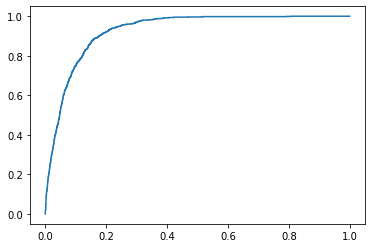

In [0]:
oversample_f(RF_f)

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.82      0.90      7955
         1.0       0.41      0.90      0.56      1084

    accuracy                           0.83      9039
   macro avg       0.70      0.86      0.73      9039
weighted avg       0.91      0.83      0.86      9039


Confusion Matrix:
 [[6530 1425]
 [ 106  978]]

AUC Score: 0.93


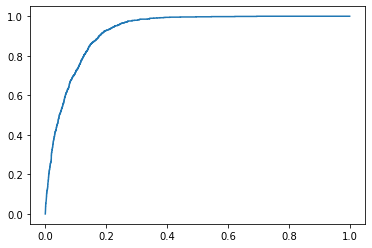

In [0]:
undersample_f(RF_f)

In [0]:
# LOGISTIC REGRESSION #

Number of features selected: 46
Test Accuracy 0.8461112954972895
[[6812 1208]
 [ 183  836]]


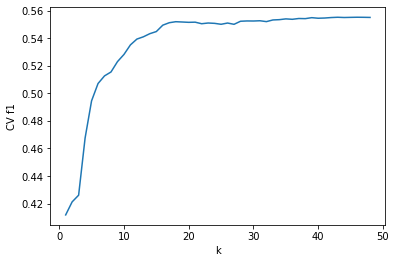

In [0]:
# ***** FEATURE SELECTION **** #

# RFE

rfe_lr = RFECV(LogisticRegression(class_weight='balanced'), cv=5, scoring='f1')
rfe_lr = rfe_lr.fit(x_f_train, y_f_train)
 
cols = x_f_train.columns[rfe_lr.support_]
acc = accuracy_score(y_f_test, rfe_lr.estimator_.predict(x_f_test[cols]))
print('Number of features selected: {}'.format(rfe_lr.n_features_))
print('Test Accuracy {}'.format(acc))
print(confusion_matrix(y_f_test, rfe_lr.estimator_.predict(x_f_test[cols])))
 
plt.figure()
plt.xlabel('k')
plt.ylabel('CV f1')
plt.plot(np.arange(1, rfe_lr.grid_scores_.size+1), rfe_lr.grid_scores_)
plt.show()

In [0]:
print(classification_report(y_f_test, rfe_lr.estimator_.predict(x_f_test[cols])))

              precision    recall  f1-score   support

         0.0       0.97      0.85      0.91      8020
         1.0       0.41      0.82      0.55      1019

    accuracy                           0.85      9039
   macro avg       0.69      0.83      0.73      9039
weighted avg       0.91      0.85      0.87      9039



In [0]:
# GRID SEARCH #

lr = rfe_lr.estimator_
lr_gs = GridSearchCV(lr,
                     param_grid = ({'class_weight':['balanced'],
                                  'C':[0.5,1,1.5,5,10],
                                  'penalty':['l1','l2']}),
                     scoring = 'f1')

lr_gs.fit(x_f_train,y_f_train)

print('Best model:', lr_gs.best_estimator_)
print('Best parameters:', lr_gs.best_params_)
print('Best score:', lr_gs.best_score_)

Best model: LogisticRegression(C=0.5, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Best parameters: {'C': 0.5, 'class_weight': 'balanced', 'penalty': 'l2'}
Best score: 0.5562525664575999


(36155, 48)

In [0]:
lr_f = lr_gs.best_estimator_.fit(x_f_train, y_f_train)

print(classification_report(y_f_test, lr_f.predict(x_f_test)))
print(confusion_matrix(y_f_test, lr_f.predict(x_f_test)))

              precision    recall  f1-score   support

         0.0       0.97      0.85      0.91      8020
         1.0       0.41      0.82      0.55      1019

    accuracy                           0.85      9039
   macro avg       0.69      0.83      0.73      9039
weighted avg       0.91      0.85      0.87      9039

[[6821 1199]
 [ 184  835]]


Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.85      0.91      8020
         1.0       0.41      0.82      0.54      1019

    accuracy                           0.85      9039
   macro avg       0.69      0.83      0.73      9039
weighted avg       0.91      0.85      0.87      9039


Confusion Matrix:
 [[6805 1215]
 [ 185  834]]

AUC Score: 0.91


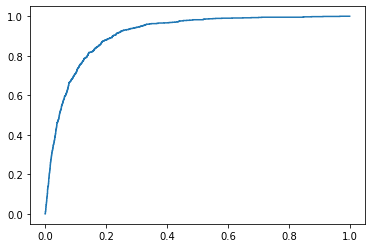

In [0]:
oversample_f(lr_f)

Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.85      0.91      8020
         1.0       0.41      0.81      0.54      1019

    accuracy                           0.85      9039
   macro avg       0.69      0.83      0.73      9039
weighted avg       0.91      0.85      0.87      9039


Confusion Matrix:
 [[6816 1204]
 [ 189  830]]

AUC Score: 0.91


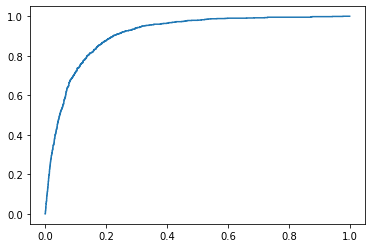

In [0]:
undersample_f(lr_f)

In [0]:
# KNN #

In [0]:
# GRID SEARCH #

knn = KNeighborsClassifier()

knn_gs = GridSearchCV(knn,
                     cv = 5,
                     param_grid = ({'n_neighbors':[2,4,6,8,10,15,20],
                                    'p':[1,2],
                                    'weights':['uniform', 'distance']}),
                     scoring = 'f1')

knn_gs.fit(x_f_train, y_f_train)

print('Best model:', knn_gs.best_estimator_)
print('Best parameters:', knn_gs.best_params_)
print('Best score:', knn_gs.best_score_)

Best model: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='distance')
Best parameters: {'n_neighbors': 2, 'p': 2, 'weights': 'distance'}
Best score: 0.38495601963978454


In [0]:
knn_f = knn_gs.best_estimator_.fit(x_f_train, y_f_train)

print(classification_report(y_f_test, knn_f.predict(x_f_test)))
print(confusion_matrix(y_f_test, knn_f.predict(x_f_test)))

              precision    recall  f1-score   support

         0.0       0.92      0.93      0.93      8020
         1.0       0.42      0.38      0.40      1019

    accuracy                           0.87      9039
   macro avg       0.67      0.66      0.66      9039
weighted avg       0.87      0.87      0.87      9039

[[7487  533]
 [ 631  388]]


Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.93      0.93      8020
         1.0       0.42      0.38      0.40      1019

    accuracy                           0.87      9039
   macro avg       0.67      0.66      0.66      9039
weighted avg       0.87      0.87      0.87      9039


Confusion Matrix:
 [[7487  533]
 [ 631  388]]

AUC Score: 0.71


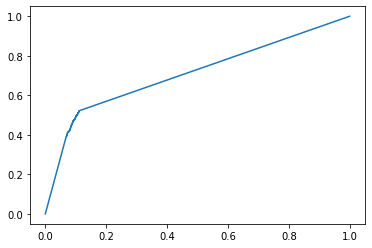

In [0]:
oversample_f(knn_f)

Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.72      0.82      8020
         1.0       0.25      0.71      0.37      1019

    accuracy                           0.72      9039
   macro avg       0.60      0.72      0.59      9039
weighted avg       0.87      0.72      0.77      9039


Confusion Matrix:
 [[5789 2231]
 [ 291  728]]

AUC Score: 0.77


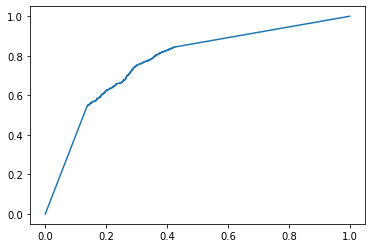

In [0]:
undersample_f(knn_f)

# No Outliers Data preperation

In [0]:
# **** NO OUTLIERS **** #

In [0]:
bank_out = pd.DataFrame(bank, copy=True)
bank_out.drop(['age_cat', 'duration_min', 'month_qtr', 
               'campaign_cat', 'pdays', 'previous'], axis=1, inplace=True)

bank_out.duration = round(bank.duration/60, 1)

bank_out.drop(bank_out[bank_out.campaign>6].index, inplace=True)
bank_out.drop(bank_out[bank_out.age>70].index, inplace=True)
bank_out.drop(bank_out[bank_out.duration>10.7].index, inplace=True)

In [0]:
bank_out = pd.get_dummies(bank_out, columns=['job', 'marital', 'education', 
                                             'contact', 'month', 'poutcome'])

In [0]:
bank_out.shape

(38672, 48)

In [0]:
scaled_out = MinMaxScaler(feature_range=(0,1)).fit_transform(bank_out)
bank_out_f = pd.DataFrame(scaled_out, columns=bank_out.columns)

In [0]:
bank_out_f.head(3)

,age,default,balance,housing,loan,day,duration,campaign,y,pre_contacted,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,0.769231,0.0,0.092259,1.0,0.0,0.133333,0.411215,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.500000,0.0,0.073067,1.0,0.0,0.133333,0.233645,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.288462,0.0,0.072822,1.0,1.0,0.133333,0.121495,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [0]:
X_out = bank_out_f.drop('y', axis=1)
y_out = bank_out_f['y']

x_out_train, x_out_test, y_out_train, y_out_test = split(X_out, y_out, test_size=0.2)

# Models - No Outliers

Number of features selected: 26
Test Accuracy 0.9269553975436329
[[6953   90]
 [ 475  217]]


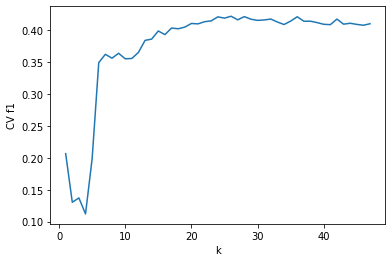

In [0]:
# RANDOM FOREST #

# ***** FEATURE SELECTION **** #

# RFE

rfe = RFECV(RandomForestClassifier(class_weight='balanced', n_estimators=100), cv=5, scoring='f1')
rfe = rfe.fit(x_out_train, y_out_train)
 
cols = x_out_train.columns[rfe.support_]
acc = accuracy_score(y_out_test, rfe.estimator_.predict(x_out_test[cols]))
print('Number of features selected: {}'.format(rfe.n_features_))
print('Test Accuracy {}'.format(acc))
print(confusion_matrix(y_out_test, rfe.estimator_.predict(x_out_test[cols])))
 
plt.figure()
plt.xlabel('k')
plt.ylabel('CV f1')
plt.plot(np.arange(1, rfe.grid_scores_.size+1), rfe.grid_scores_)
plt.show()

In [0]:
print(classification_report(y_out_test, rfe.estimator_.predict(x_out_test[cols])))

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96      7043
         1.0       0.71      0.31      0.43       692

    accuracy                           0.93      7735
   macro avg       0.82      0.65      0.70      7735
weighted avg       0.92      0.93      0.91      7735



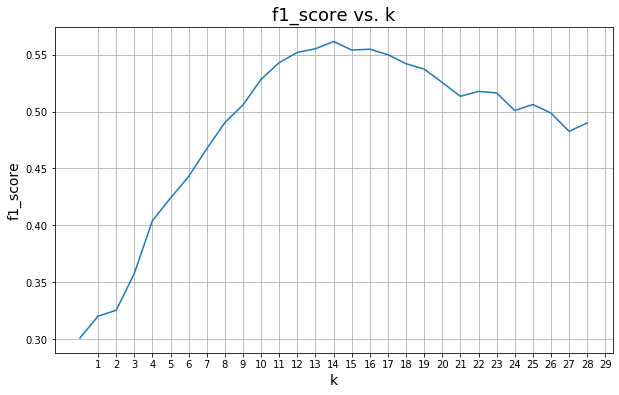

In [0]:
f1_scores = []
for k in range(1, 30):
    model = RandomForestClassifier(n_estimators=200, max_depth=k, 
                                   class_weight='balanced', max_features=25).fit(x_out_train, y_out_train)
    f1_scores.append(f1_score(y_true=y_out_test,
                              y_pred=model.predict(x_out_test)))

plt.figure(figsize=(10,6))
plt.plot(f1_scores)
plt.xlabel('k', fontsize=14)
plt.xticks(range(1,30))
plt.ylabel('f1_score', fontsize=14)
plt.title('f1_score vs. k', fontsize=18)
plt.grid()

plt.show()

In [0]:
RF_out = RandomForestClassifier(max_features=25, n_estimators=300, max_depth=15, class_weight='balanced')

scores = cross_val_score(RF_out, x_out_train, y_out_train, cv=10)

print("Scores :",scores)
print("Average:",scores.mean())
print("STD:", scores.std())

Scores : [0.91793215 0.91790562 0.91984486 0.90174531 0.91531997 0.91305753
 0.91367604 0.91367604 0.91399935 0.91820239]
Average: 0.9145359283026051
STD: 0.004823731126520001


In [0]:
RF_out.fit(x_out_train, y_out_train)

print(classification_report(y_out_test, RF_out.predict(x_out_test)))
print(confusion_matrix(y_out_test, RF_out.predict(x_out_test)))

              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95      7043
         1.0       0.51      0.63      0.56       692

    accuracy                           0.91      7735
   macro avg       0.73      0.78      0.76      7735
weighted avg       0.92      0.91      0.92      7735

[[6619  424]
 [ 256  436]]


Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.92      0.95      7043
         1.0       0.48      0.72      0.57       692

    accuracy                           0.90      7735
   macro avg       0.72      0.82      0.76      7735
weighted avg       0.93      0.90      0.91      7735


Confusion Matrix:
 [[6496  547]
 [ 196  496]]

AUC Score: 0.92


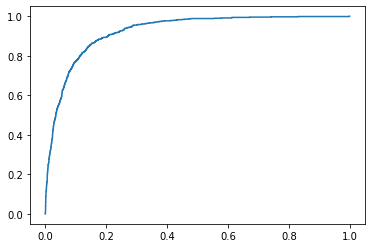

In [0]:
oversample_out(RF_out)

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.83      0.90      7043
         1.0       0.33      0.88      0.48       692

    accuracy                           0.83      7735
   macro avg       0.66      0.85      0.69      7735
weighted avg       0.93      0.83      0.86      7735


Confusion Matrix:
 [[5814 1229]
 [  81  611]]

AUC Score: 0.92


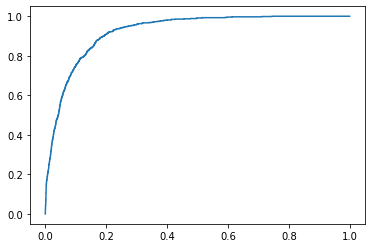

In [0]:
undersample_out(RF_out)

In [0]:
# LOGISTIC REGRESSION #

Number of features selected: 29
Test Accuracy 0.8245636716224951
[[5816 1227]
 [ 130  562]]


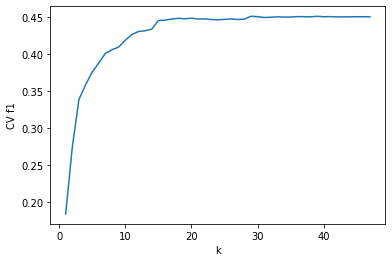

In [0]:
# ***** FEATURE SELECTION **** #

# RFE

rfe_lr_out = RFECV(LogisticRegression(class_weight='balanced'), cv=5, scoring='f1')
rfe_lr_out = rfe_lr_out.fit(x_out_train, y_out_train)
 
cols = x_out_train.columns[rfe_lr_out.support_]
acc = accuracy_score(y_out_test, rfe_lr_out.estimator_.predict(x_out_test[cols]))
print('Number of features selected: {}'.format(rfe_lr_out.n_features_))
print('Test Accuracy {}'.format(acc))
print(confusion_matrix(y_out_test, rfe_lr_out.estimator_.predict(x_out_test[cols])))
 
plt.figure()
plt.xlabel('k')
plt.ylabel('CV f1')
plt.plot(np.arange(1, rfe_lr_out.grid_scores_.size+1), rfe_lr_out.grid_scores_)
plt.show()

In [0]:
print(classification_report(y_out_test, rfe_lr_out.estimator_.predict(x_out_test[cols])))

              precision    recall  f1-score   support

         0.0       0.98      0.83      0.90      7043
         1.0       0.31      0.81      0.45       692

    accuracy                           0.82      7735
   macro avg       0.65      0.82      0.67      7735
weighted avg       0.92      0.82      0.86      7735



In [0]:
# GRID SEARCH #

lr = rfe_lr_out.estimator_
lr_gs = GridSearchCV(lr,
                     cv = 5,
                     param_grid = ({'class_weight':['balanced'],
                                    'C':[0.5,1,1.5,5,10],
                                    'penalty':['l1','l2']}),
                     scoring = 'f1')

lr_gs.fit(x_out_train, y_out_train)

print('Best model:', lr_gs.best_estimator_)
print('Best parameters:', lr_gs.best_params_)
print('Best score:', lr_gs.best_score_)

Best model: LogisticRegression(C=10, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Best parameters: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2'}
Best score: 0.4507829516112972


In [0]:
lr_out = lr_gs.best_estimator_.fit(x_out_train, y_out_train)

print(classification_report(y_out_test, lr_out.predict(x_out_test)))
print(confusion_matrix(y_out_test, lr_out.predict(x_out_test)))

              precision    recall  f1-score   support

         0.0       0.98      0.83      0.90      7043
         1.0       0.32      0.83      0.46       692

    accuracy                           0.83      7735
   macro avg       0.65      0.83      0.68      7735
weighted avg       0.92      0.83      0.86      7735

[[5828 1215]
 [ 121  571]]


Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.83      0.90      7043
         1.0       0.32      0.83      0.46       692

    accuracy                           0.83      7735
   macro avg       0.65      0.83      0.68      7735
weighted avg       0.92      0.83      0.86      7735


Confusion Matrix:
 [[5844 1199]
 [ 120  572]]

AUC Score: 0.9


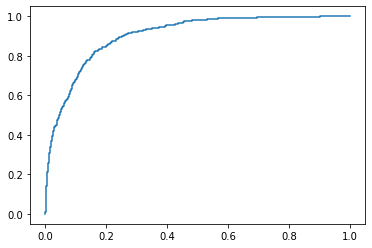

In [0]:
oversample_out(lr_out)

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.83      0.90      7043
         1.0       0.32      0.82      0.46       692

    accuracy                           0.83      7735
   macro avg       0.65      0.82      0.68      7735
weighted avg       0.92      0.83      0.86      7735


Confusion Matrix:
 [[5814 1229]
 [ 123  569]]

AUC Score: 0.9


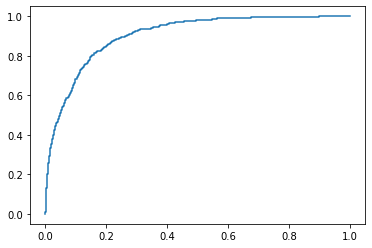

In [0]:
undersample_out(lr_out)

In [0]:
# KNN #

In [0]:
# GRID SEARCH #

knn = KNeighborsClassifier()

knn_gs = GridSearchCV(knn,
                      cv = 5,
                      param_grid = ({'n_neighbors':[2,4,6,8,10,15,20],
                                    'p':[1,2],
                                    'weights':['uniform', 'distance']}),
                      scoring = 'f1')

knn_gs.fit(x_out_train, y_out_train)

print('Best model:', knn_gs.best_estimator_)
print('Best parameters:', knn_gs.best_params_)
print('Best score:', knn_gs.best_score_)

Best model: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=1,
                     weights='distance')
Best parameters: {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Best score: 0.41854855568706845


In [0]:
knn_out = knn_gs.best_estimator_.fit(x_out_train, y_out_train)

print(classification_report(y_out_test, knn_out.predict(x_out_test)))
print(confusion_matrix(y_out_test, knn_out.predict(x_out_test)))

              precision    recall  f1-score   support

         0.0       0.94      0.97      0.95      7043
         1.0       0.55      0.34      0.42       692

    accuracy                           0.92      7735
   macro avg       0.74      0.66      0.69      7735
weighted avg       0.90      0.92      0.91      7735

[[6846  197]
 [ 455  237]]


Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.92      0.94      7043
         1.0       0.39      0.51      0.45       692

    accuracy                           0.89      7735
   macro avg       0.67      0.72      0.69      7735
weighted avg       0.90      0.89      0.89      7735


Confusion Matrix:
 [[6498  545]
 [ 337  355]]

AUC Score: 0.78


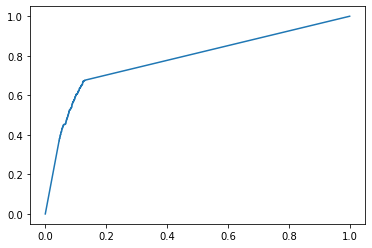

In [0]:
oversample_out(knn_out)

Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.82      0.89      7043
         1.0       0.28      0.73      0.40       692

    accuracy                           0.81      7735
   macro avg       0.62      0.77      0.64      7735
weighted avg       0.91      0.81      0.84      7735


Confusion Matrix:
 [[5746 1297]
 [ 189  503]]

AUC Score: 0.84


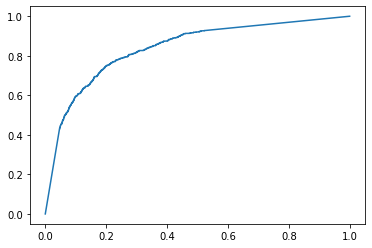

In [0]:
undersample_out(knn_out)

#RESULTS

In [0]:
# **** RESULTS **** #

In [0]:
x_f_oversample = pd.concat([x_f_train, y_f_train], axis=1)
true_f = x_f_oversample[x_f_oversample['y']==1]
false_f = x_f_oversample[x_f_oversample['y']==0]
true_f_oversample = resample(true_f,
                             replace=True, 
                             n_samples=len(false_f),
                             random_state=2732)  
oversample_f = pd.concat([false_f, true_f_oversample])
oversample_f['y'].value_counts()
x_train_os_f = oversample_f.drop('y', axis=1)
y_train_os_f = oversample_f['y']

x_f_undersample = pd.concat([x_f_train, y_f_train], axis=1)
true_f_u = x_f_undersample[x_f_undersample['y']==1]
false_f_u = x_f_undersample[x_f_undersample['y']==0]
false_f_undersample = resample(false_f_u,
                              replace=True, 
                              n_samples=len(true_f_u),
                              random_state=7)  
undersample_f = pd.concat([false_f_undersample, true_f_u])
undersample_f['y'].value_counts()
y_f_train_us = undersample_f['y']
x_f_train_us = undersample_f.drop('y', axis=1)

In [0]:
x_out_oversample = pd.concat([x_out_train, y_out_train], axis=1)
true_out = x_out_oversample[x_out_oversample['y']==1]
false_out = x_out_oversample[x_out_oversample['y']==0]
true_out_oversample = resample(true_out,
                               replace=True, 
                               n_samples=len(false_out),
                               random_state=2732)  
oversample_out = pd.concat([false_out, true_out_oversample])
oversample_out['y'].value_counts()
x_out_train_os = oversample_out.drop('y', axis=1)
y_out_train_os = oversample_out['y']

x_out_undersample = pd.concat([x_out_train, y_out_train], axis=1)
true_out_u = x_out_undersample[x_out_undersample['y']==1]
false_out_u = x_out_undersample[x_out_undersample['y']==0]
false_out_undersample = resample(false_out_u,
                                 replace=True, 
                                 n_samples=len(true_out_u),
                                 random_state=7)  
undersample_out = pd.concat([false_out_undersample, true_out_u])
undersample_out['y'].value_counts()
y_out_train_us = undersample_out['y']
x_out_train_us = undersample_out.drop('y', axis=1)

In [0]:
# ROC CURVE & SCORE FINAL

# RF_f
scores_rff = RF_f.predict_proba(x_f_test)[:, 1]
fpr_rff, tpr_rff, thresholds = roc_curve(y_f_test, scores_rff, pos_label= 1)
auc_rff = round(auc(fpr_rff, tpr_rff),2)
# RF_f_os
RF_f_os = RF_f.fit(x_train_os_f, y_train_os_f)
RF_f_os_pred = RF_f_os.predict(x_f_test)
scores_RF_f_os = RF_f_os.predict_proba(x_f_test)[:, 1]
fpr_RF_f_os, tpr_RF_f_os, thresholds = roc_curve(y_f_test, scores_RF_f_os, pos_label= 1)
auc_RF_f_os = round(auc(fpr_RF_f_os, tpr_RF_f_os),2)
# RF_f_us
RF_f_us = RF_f.fit(x_f_train_us, y_f_train_us)
RF_f_us_pred = RF_f_us.predict(x_f_test)
scores_RF_f_us = RF_f_us.predict_proba(x_f_test)[:, 1]
fpr_RF_f_us, tpr_RF_f_us, thresholds = roc_curve(y_f_test, scores_RF_f_us, pos_label= 1)
auc_RF_f_us = round(auc(fpr_RF_f_us, tpr_RF_f_us),2)

# lr_f
scores_lr_f = lr_f.predict_proba(x_f_test)[:, 1]
fpr_lr_f, tpr_lr_f, thresholds = roc_curve(y_f_test, scores_lr_f, pos_label= 1)
auc_lr_f = round(auc(fpr_lr_f, tpr_lr_f),2)
# lr_f_os
lr_f_os = lr_f.fit(x_train_os_f, y_train_os_f)
lr_f_os_pred = lr_f_os.predict(x_f_test)
scores_lr_f_os = lr_f_os.predict_proba(x_f_test)[:, 1]
fpr_lr_f_os, tpr_lr_f_os, thresholds = roc_curve(y_f_test, scores_lr_f_os, pos_label= 1)
auc_lr_f_os = round(auc(fpr_lr_f_os, tpr_lr_f_os),2)
# lr_f_us
lr_f_us = lr_f.fit(x_f_train_us, y_f_train_us)
lr_f_us_pred = lr_f_us.predict(x_f_test)
scores_lr_f_us = lr_f_us.predict_proba(x_f_test)[:, 1]
fpr_lr_f_us, tpr_lr_f_us, thresholds = roc_curve(y_f_test, scores_lr_f_us, pos_label= 1)
auc_lr_f_us = round(auc(fpr_lr_f_us, tpr_lr_f_us),2)

# knn_f
scores_knn_f = knn_f.predict_proba(x_f_test)[:, 1]
fpr_knn_f, tpr_knn_f, thresholds = roc_curve(y_f_test, scores_knn_f, pos_label= 1)
auc_knn_f = round(auc(fpr_knn_f, tpr_knn_f),2)
# knn_f_os
knn_f_os = knn_f.fit(x_train_os_f, y_train_os_f)
knn_f_os_pred = knn_f_os.predict(x_f_test)
scores_knn_f_os = knn_f_os.predict_proba(x_f_test)[:, 1]
fpr_knn_f_os, tpr_knn_f_os, thresholds = roc_curve(y_f_test, scores_knn_f_os, pos_label= 1)
auc_knn_f_os = round(auc(fpr_knn_f_os, tpr_knn_f_os),2)
# knn_f_us
knn_f_us = knn_f.fit(x_f_train_us, y_f_train_us)
knn_f_us_pred = knn_f_us.predict(x_f_test)
scores_knn_f_us = knn_f_us.predict_proba(x_f_test)[:, 1]
fpr_knn_f_us, tpr_knn_f_us, thresholds = roc_curve(y_f_test, scores_knn_f_us, pos_label= 1)
auc_knn_f_us = round(auc(fpr_knn_f_us, tpr_knn_f_us),2)

In [0]:
# ROC CURVE & SCORE NO OUTLIERS

# RF_out
scores_rf_out = RF_out.predict_proba(x_out_test)[:, 1]
fpr_rf_out, tpr_rf_out, thresholds = roc_curve(y_out_test, scores_rf_out, pos_label= 1)
auc_rf_out = round(auc(fpr_rf_out, tpr_rf_out),2)
# RF_out_os
RF_out_os = RF_out.fit(x_out_train_os, y_out_train_os)
RF_out_os_pred = RF_out_os.predict(x_out_test)
scores_RF_out_os = RF_out_os.predict_proba(x_out_test)[:, 1]
fpr_RF_out_os, tpr_RF_out_os, thresholds = roc_curve(y_out_test, scores_RF_out_os, pos_label= 1)
auc_RF_out_os = round(auc(fpr_RF_out_os, tpr_RF_out_os),2)
# RF_out_us
RF_out_us = RF_out.fit(x_out_train_us, y_out_train_us)
RF_out_us_pred = RF_out_us.predict(x_out_test)
scores_RF_out_us = RF_out_us.predict_proba(x_out_test)[:, 1]
fpr_RF_out_us, tpr_RF_out_us, thresholds = roc_curve(y_out_test, scores_RF_out_us, pos_label= 1)
auc_RF_out_us = round(auc(fpr_RF_out_us, tpr_RF_out_us),2)

# lr_out
scores_lr_out = lr_out.predict_proba(x_out_test)[:, 1]
fpr_lr_out, tpr_lr_out, thresholds = roc_curve(y_out_test, scores_lr_out, pos_label= 1)
auc_lr_out = round(auc(fpr_lr_out, tpr_lr_out),2)
# lr_out_os
lr_out_os = lr_out.fit(x_out_train_os, y_out_train_os)
lr_out_os_pred = lr_out_os.predict(x_out_test)
scores_lr_out_os = lr_out_os.predict_proba(x_out_test)[:, 1]
fpr_lr_out_os, tpr_lr_out_os, thresholds = roc_curve(y_out_test, scores_lr_out_os, pos_label= 1)
auc_lr_out_os = round(auc(fpr_lr_out_os, tpr_lr_out_os),2)
# lr_out_us
lr_out_us = lr_out.fit(x_out_train_us, y_out_train_us)
lr_out_us_pred = lr_out_us.predict(x_out_test)
scores_lr_out_us = lr_out_us.predict_proba(x_out_test)[:, 1]
fpr_lr_out_us, tpr_lr_out_us, thresholds = roc_curve(y_out_test, scores_lr_out_us, pos_label= 1)
auc_lr_out_us = round(auc(fpr_lr_out_us, tpr_lr_out_us),2)

# knn_out
scores_knn_out = knn_out.predict_proba(x_out_test)[:, 1]
fpr_knn_out, tpr_knn_out, thresholds = roc_curve(y_out_test, scores_knn_out, pos_label= 1)
auc_knn_out = round(auc(fpr_knn_out, tpr_knn_out),2)
# knn_out_os
knn_out_os = knn_out.fit(x_out_train_os, y_out_train_os)
knn_out_os_pred = knn_out_os.predict(x_out_test)
scores_knn_out_os = knn_out_os.predict_proba(x_out_test)[:, 1]
fpr_knn_out_os, tpr_knn_out_os, thresholds = roc_curve(y_out_test, scores_knn_out_os, pos_label= 1)
auc_knn_out_os = round(auc(fpr_knn_out_os, tpr_knn_out_os),2)
# knn_out_us
knn_out_us = knn_out.fit(x_out_train_us, y_out_train_us)
knn_out_us_pred = knn_out_us.predict(x_out_test)
scores_knn_out_us = knn_out_us.predict_proba(x_out_test)[:, 1]
fpr_knn_out_us, tpr_knn_out_us, thresholds = roc_curve(y_out_test, scores_knn_out_us, pos_label= 1)
auc_knn_out_us = round(auc(fpr_knn_out_us, tpr_knn_out_us),2)

In [0]:
cm_rf_f = confusion_matrix(y_f_test, RF_f.predict(x_f_test))
cm_rf_f_os = confusion_matrix(y_f_test, RF_f_os_pred)
cm_rf_f_us = confusion_matrix(y_f_test, RF_f_us_pred)
# cm_lr_f = confusion_matrix(y_f_test, lr_f.predict(x_f_test))
# cm_lr_f_os = confusion_matrix(y_f_test, lr_f_os.predict(x_f_test))
# cm_lr_f_us = confusion_matrix(y_f_test, lr_f_us.predict(x_f_test))
# cm_knn_f = confusion_matrix(y_f_test, knn_f.predict(x_f_test))
# cm_knn_f_os = confusion_matrix(y_f_test, knn_f_os.predict(x_f_test))
# cm_knn_f_us = confusion_matrix(y_f_test, knn_f_us.predict(x_f_test))

cm_rf_out = confusion_matrix(y_out_test, RF_out.predict(x_out_test))
cm_rf_out_os = confusion_matrix(y_out_test, RF_out_os_pred)
cm_rf_out_us = confusion_matrix(y_out_test, RF_out_us_pred)
# cm_lr_out = confusion_matrix(y_out_test, lr_out.predict(x_out_test))
# cm_lr_out_os = confusion_matrix(y_out_test, lr_out_os.predict(x_out_test))
# cm_lr_out_us = confusion_matrix(y_out_test, lr_out_us.predict(x_out_test))
# cm_knn_out = confusion_matrix(y_out_test, knn_out.predict(x_out_test))
# cm_knn_out_os = confusion_matrix(y_out_test, knn_out_os.predict(x_out_test))
# cm_knn_out_us = confusion_matrix(y_out_test, knn_out_us.predict(x_out_test))

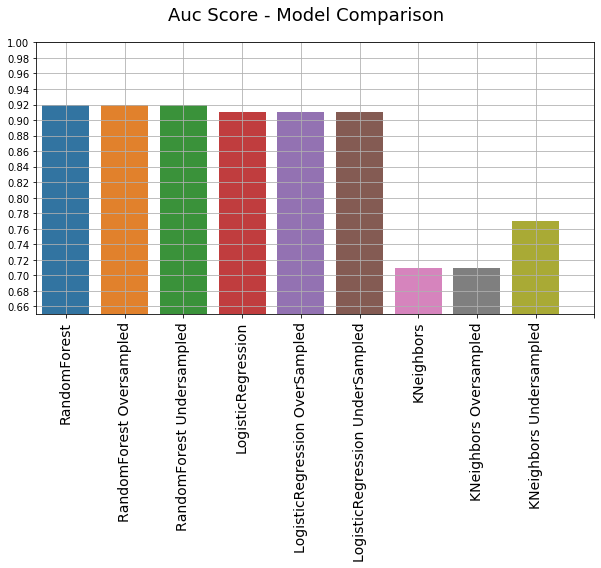

In [0]:
auc_scores_f = [auc_rff, auc_RF_f_os, auc_RF_f_us,
                auc_lr_f, auc_lr_f_os, auc_lr_f_us,
                auc_knn_f, auc_knn_f_os, auc_knn_f_us]

auc_scores_out = [auc_rf_out, auc_RF_out_os, auc_RF_out_us,
                  auc_lr_out, auc_lr_out_os, auc_lr_out_us,
                  auc_knn_out, auc_knn_out_os, auc_knn_out_us]

algo_f = ['RandomForest', 'RandomForest Oversampled', 'RandomForest Undersampled', 
          'LogisticRegression', 'LogisticRegression OverSampled', 'LogisticRegression UnderSampled',
          'KNeighbors', 'KNeighbors Oversampled', 'KNeighbors Undersampled']

auc_dic_f = {'score':auc_scores_f}
auc_df_f = pd.DataFrame(auc_dic_f, index=algo_f)
y_pos_f = np.arange(0, 10)

# fig, ax = plt.subplots(1, 2, figsize=(20,6))
plt.figure(figsize=(10,5))
plt.suptitle('Auc Score - Model Comparison', fontsize=18)
sns.barplot(x=algo_f, y=auc_scores_f)
# ax[0].set_title('Final Data', fontsize=16)
plt.xticks(y_pos_f, algo_f, fontsize=14, rotation=90)
plt.yticks(np.arange(0, 1.01, step=0.02))
plt.ylim(0.65,1)
plt.grid()

plt.show()

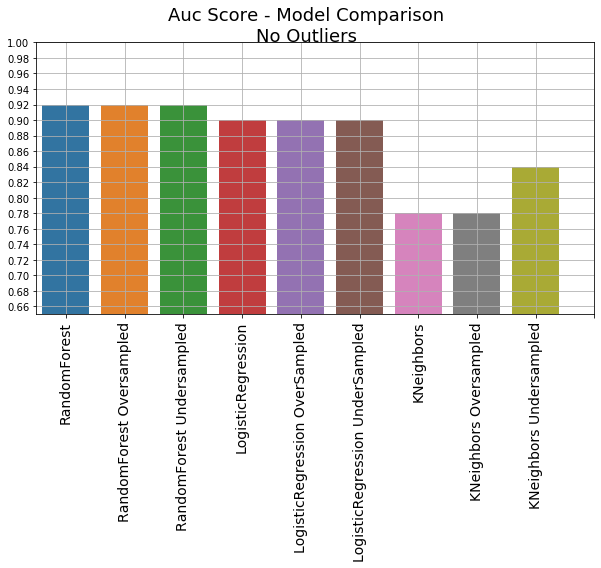

In [0]:
plt.figure(figsize=(10,5))
sns.barplot(x=algo_f, y=auc_scores_out)
plt.suptitle('Auc Score - Model Comparison\nNo Outliers\n', fontsize=18)
plt.xticks(y_pos_f, algo_f, fontsize=14, rotation=90)
plt.yticks(np.arange(0, 1.01, step=0.02))
plt.ylim(0.65,1)
plt.grid()

plt.show()

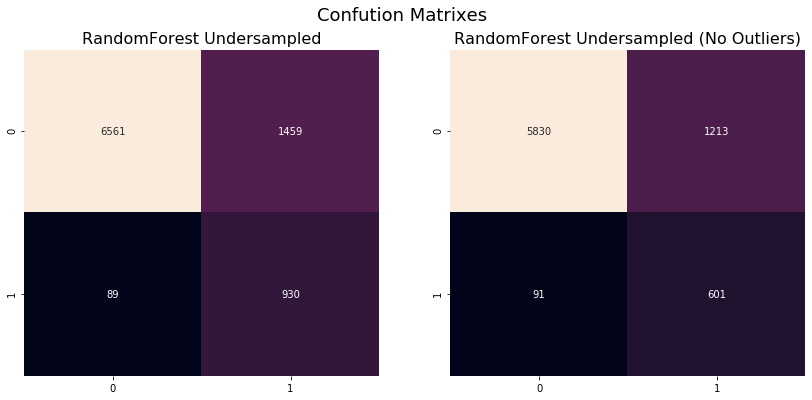

In [0]:
# **** CONFUSION MATRIXES ****

fig, axs = plt.subplots(1,2, figsize=(14,6))
plt.suptitle('Confution Matrixes', fontsize=18)

sns.heatmap(pd.DataFrame(cm_rf_f_us), annot=True, cbar=False, fmt='d', ax=axs[0])
axs[0].set_title('RandomForest Undersampled', fontsize=16)
sns.heatmap(pd.DataFrame(cm_rf_out_us), annot=True, cbar=False, fmt='d', ax=axs[1])
axs[1].set_title('RandomForest Undersampled (No Outliers)', fontsize=16)

plt.show()

Conclusion Results:
 - In my opinion, the best option is the Random Forest Undersampled because it covers the most clients that will make a term deposit, even thogh the prediction of True and False negative aren't good 